In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json

import sys

sys.path.append("../../")

##################################################################
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["CUDA_VISIBLE_DEVICES"] = "1,2,3,4,5,6,7"
##################################################################

import logging
from src.utils import logging_utils
from src.utils import env_utils

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

import torch
import transformers

logger.info(f"{torch.__version__=}, {torch.version.cuda=}")
logger.info(
    f"{torch.cuda.is_available()=}, {torch.cuda.device_count()=}, {torch.cuda.get_device_name()=}"
)
logger.info(f"{transformers.__version__=}")

2025-09-20 23:40:02 __main__ INFO     torch.__version__='2.7.0+cu126', torch.version.cuda='12.6'
2025-09-20 23:40:02 __main__ INFO     torch.cuda.is_available()=True, torch.cuda.device_count()=7, torch.cuda.get_device_name()='NVIDIA A100 80GB PCIe'
2025-09-20 23:40:02 __main__ INFO     transformers.__version__='4.55.3'


In [3]:
from src.utils.training_utils import get_device_map

# model_key = "meta-llama/Llama-3.2-3B"
# model_key = "meta-llama/Llama-3.1-8B"
# model_key = "meta-llama/Llama-3.1-70B-Instruct"
model_key = "meta-llama/Llama-3.3-70B-Instruct"
# model_key = "meta-llama/Llama-3.1-405B-Instruct"

# model_key = "google/gemma-2-9b-it"
# model_key = "google/gemma-3-12b-it"
# model_key = "google/gemma-2-27b-it"

# model_key = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"

# model_key = "allenai/OLMo-2-1124-7B-Instruct"
# model_key = "allenai/OLMo-7B-0424-hf"

# model_key = "Qwen/Qwen2-7B"
# model_key = "Qwen/Qwen2.5-14B-Instruct"
# model_key = "Qwen/Qwen2.5-32B-Instruct"
# model_key = "Qwen/Qwen2.5-72B-Instruct"

# model_key = "Qwen/Qwen3-1.7B"
# model_key = "Qwen/Qwen3-4B"
# model_key = "Qwen/Qwen3-8B"
# model_key = "Qwen/Qwen3-14B"
# model_key = "Qwen/Qwen3-32B"

# device_map = get_device_map(model_key, 30, n_gpus=8)
# device_map

2025-09-20 23:40:06 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks/checking_head_generalization, stdin=None, shell=False, universal_newlines=False)
2025-09-20 23:40:06 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks/checking_head_generalization, stdin=None, shell=False, universal_newlines=False)
2025-09-20 23:40:07 wandb.docker.auth DEBUG    Trying paths: ['/disk/u/arnab/.docker/config.json', '/disk/u/arnab/.dockercfg']
2025-09-20 23:40:07 wandb.docker.auth DEBUG    No config file found


In [4]:
from src.models import ModelandTokenizer

# from transformers import BitsAndBytesConfig

mt = ModelandTokenizer(
    model_key=model_key,
    torch_dtype=torch.bfloat16,
    # device_map=device_map,
    device_map="auto",
    # quantization_config = BitsAndBytesConfig(
    #     # load_in_4bit=True
    #     load_in_8bit=True
    # )
    attn_implementation="eager",
)

2025-09-20 23:40:08 src.models WARNING  meta-llama/Llama-3.3-70B-Instruct not found in /disk/u/arnab/Codes/Models
If not found in cache, model will be downloaded from HuggingFace to cache directory
2025-09-20 23:40:08 urllib3.connectionpool DEBUG    Starting new HTTPS connection (1): huggingface.co:443


2025-09-20 23:40:08 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/config.json HTTP/1.1" 200 0
2025-09-20 23:40:08 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2025-09-20 23:40:08 urllib3.connectionpool DEBUG    https://huggingface.co:443 "GET /api/models/meta-llama/Llama-3.3-70B-Instruct/tree/main/additional_chat_templates?recursive=False&expand=False HTTP/1.1" 404 64


Loading checkpoint shards:   0%|          | 0/30 [00:00<?, ?it/s]

2025-09-20 23:40:57 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/generation_config.json HTTP/1.1" 200 0
2025-09-20 23:40:57 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/custom_generate/generate.py HTTP/1.1" 404 0
2025-09-20 23:40:57 src.models INFO     loaded model <meta-llama/Llama-3.3-70B-Instruct> | size: 134570.516 MB | dtype: torch.bfloat16 | device: cuda:0


In [5]:
from src.selection.data import SelectOneTask, CountingTask

#################################################################################
TASK_CLS = SelectOneTask
prompt_template_idx = 3
# TASK_CLS = CountingTask
# prompt_template_idx = 1
N_DISTRACTORS = 5
OPTION_STYLE = "single_line"
#################################################################################

select_task = TASK_CLS.load(
    path=os.path.join(
        env_utils.DEFAULT_DATA_DIR, 
        "selection", 
        # "profession.json"
        # "nationality.json"
        "objects.json"
    )
)

print(select_task)

['name', 'prompt_templates', 'odd_one_prompt_templates', 'order_prompt_templates', 'count_prompt_templates', 'yes_no_prompt_templates', 'first_item_in_cat_prompt_templates', 'last_item_in_cat_prompt_templates', 'categories', 'exclude_categories']
SelectOneTask: (different objects)
Categories: fruit(15), vehicle(15), furniture(15), animal(15), music instrument(15), clothing(15), electronics(14), sport equipment(15), kitchen appliance(15), vegetable(14), building(15), office supply(15), bathroom item(15), flower(15), tree(15), jewelry(15)



In [6]:
sample = select_task.get_random_sample(
    mt = mt,
    option_style=OPTION_STYLE,
    prompt_template_idx=prompt_template_idx,
    # category="actor",
    # category="Brazil"
    category="fruit",
    filter_by_lm_prediction=False,
)

print(sample.prompt(), ">>", f'"{mt.tokenizer.decode([sample.ans_token_id])}"')

Options: Surfboard, Xylophone, Kiwi, Anklet, Projector, Sofa.
Which among these objects mentioned above is a fruit?
Answer: >> " Ki"


## Loading the heads

2025-09-20 23:46:05 matplotlib DEBUG    matplotlib data path: /disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/matplotlib/mpl-data
2025-09-20 23:46:05 matplotlib DEBUG    CONFIGDIR=/disk/u/arnab/.config/matplotlib
2025-09-20 23:46:05 matplotlib DEBUG    interactive is False
2025-09-20 23:46:05 matplotlib DEBUG    platform is linux
2025-09-20 23:46:05 matplotlib DEBUG    CACHEDIR=/disk/u/arnab/.cache/matplotlib
2025-09-20 23:46:05 matplotlib.font_manager DEBUG    Using fontManager instance from /disk/u/arnab/.cache/matplotlib/fontlist-v390.json
2025-09-20 23:46:05 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-09-20 23:46:05 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-09-20 23:46:05 matplotlib.font_manager DEBUG    findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2025-09-20 23:46:05 matplotlib.font

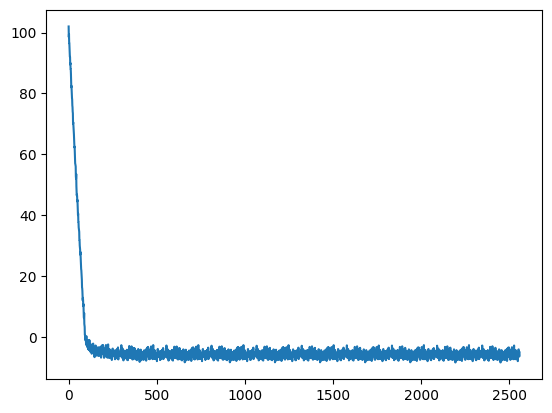

In [7]:
from matplotlib import pyplot as plt
import numpy as np

# optimized_path = os.path.join(
#     env_utils.DEFAULT_RESULTS_DIR,
#     "selection/optimized_backup_heads",
#     mt.name.split("/")[-1],
#     f"{select_task.task_name}.npz"
# )

optimized_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection/optimized_heads",
    model_key.split("/")[-1],
    "distinct_options",
    f"{select_task.task_name}",
    # "legacy",
    "epoch_10.npz"
)

# optimized_path = os.path.join(
#     env_utils.DEFAULT_RESULTS_DIR,
#     "test_opt_code",
#     model_key.split("/")[-1],
#     "distinct_options",
#     f"{select_task.task_name}",
#     "legacy",
#     "epoch_10.npz"
# )

optimization_results = np.load(optimized_path, allow_pickle=True)
plt.plot(optimization_results["losses"])
plt.show()

79


(True, True)

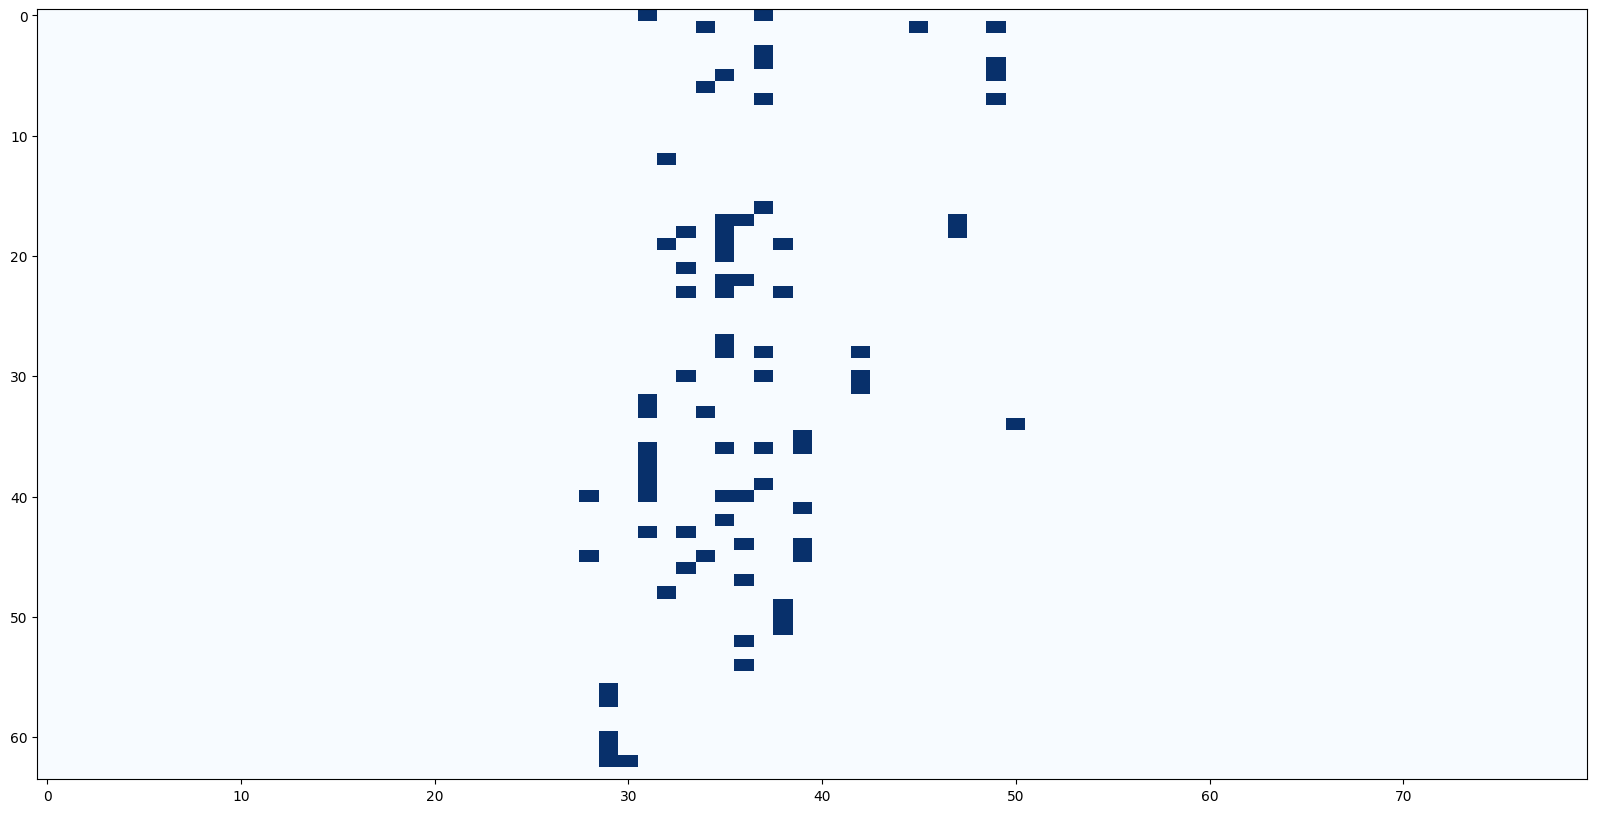

In [8]:
plt.figure(figsize=(20, 10))

optimal_head_mask = torch.tensor(optimization_results["optimal_mask"]).to(torch.float32)
optimal_head_mask[52:, :] = 0.0

plt.imshow(
    optimal_head_mask.T.numpy(),
    cmap="Blues",
    aspect="auto",
    vmin=0,
    vmax=1,
)

optimized_heads = torch.nonzero(optimal_head_mask > 0.5, as_tuple=False).tolist()
optimized_heads = [
    (layer_idx, head_idx) for layer_idx, head_idx in optimized_heads
]
print(len(optimized_heads))

HEADS = optimized_heads

(35, 19) in HEADS, (35, 19) in optimized_heads
# [(29, 3) in HEADS]

In [9]:
from src.attention import get_attention_matrices
from src.selection.functional import (
    verify_head_patterns,
    get_patches_to_verify_independent_enrichment,
)

attn_pattern = verify_head_patterns(
    prompt=sample.prompt(option_style="single_line"),
    options=sample.options,
    mt=mt,
    heads=optimized_heads,
    # heads = HEADS,
    # heads = [(35, 19)],
    start_from=1
)

2025-09-20 23:46:09 src.selection.functional DEBUG    Predictions: ['" Ki"[30558] (p=0.867, logit=22.875)', '" The"[578] (p=0.063, logit=20.250)', '" Among"[22395] (p=0.038, logit=19.750)', '" A"[362] (p=0.012, logit=18.625)', '" ki"[20548] (p=0.003, logit=17.125)']
2025-09-20 23:46:09 src.selection.functional INFO     Combined attention matrix for all heads


# Validating Against Other Reduce Tasks

## SelectOne Task

In [10]:
from src.selection.data import SelectionSample, SelectOneTask

select_one_task = SelectOneTask.load(
    path=os.path.join(
        env_utils.DEFAULT_DATA_DIR, 
        "selection", 
        "objects.json"
        # "profession.json"
        # "nationality.json"
        # "landmarks.json"
        # "rhymes.json"
    )
)
print(select_one_task)
print(select_one_task.exclude_categories)

['name', 'prompt_templates', 'odd_one_prompt_templates', 'order_prompt_templates', 'count_prompt_templates', 'yes_no_prompt_templates', 'first_item_in_cat_prompt_templates', 'last_item_in_cat_prompt_templates', 'categories', 'exclude_categories']
SelectOneTask: (different objects)
Categories: fruit(15), vehicle(15), furniture(15), animal(15), music instrument(15), clothing(15), electronics(14), sport equipment(15), kitchen appliance(15), vegetable(14), building(15), office supply(15), bathroom item(15), flower(15), tree(15), jewelry(15)

{'fruit': ['flower', 'tree', 'vegetable'], 'flower': ['fruit', 'tree', 'vegetable'], 'tree': ['fruit', 'flower'], 'vegetable': ['fruit', 'flower'], 'electronics': ['kitchen appliance', 'office supply'], 'kitchen appliance': ['electronics', 'office supply'], 'office supply': ['electronics', 'kitchen appliance']}


In [11]:
test_sample = select_one_task.get_random_sample(
    mt = mt,
    option_style=OPTION_STYLE,
    prompt_template_idx=3,
    # category="fruit",
    # category="actor",
    # category="United Kingdom",
    filter_by_lm_prediction=True,
)
# test_sample.prompt_template = "Recall the nationality of these people:\n" + test_sample.prompt_template
# test_sample.prompt_template = "Recall which country these landmarks are located in:\n" + test_sample.prompt_template
print(test_sample.prompt(), ">>", f'"{mt.tokenizer.decode([test_sample.ans_token_id])}"')
test_sample.prediction

Options: Train, Giraffe, Boxing gloves, Library, Potato, Recliner.
Which among these objects mentioned above is a animal?
Answer: >> " Gir"


[PredictedToken(token=' Gir', prob=0.6484375, logit=21.375, token_id=48035, metadata=None),
 PredictedToken(token=' The', prob=0.14453125, logit=19.875, token_id=578, metadata=None),
 PredictedToken(token=' A', prob=0.09912109375, logit=19.5, token_id=362, metadata=None),
 PredictedToken(token=' Among', prob=0.060302734375, logit=19.0, token_id=22395, metadata=None),
 PredictedToken(token=' ', prob=0.00811767578125, logit=17.0, token_id=220, metadata=None)]

In [12]:
attn_pattern = verify_head_patterns(
    prompt=test_sample.prompt(),
    options=test_sample.options,
    mt=mt,
    heads=optimized_heads,
    # heads = HEADS,
    # heads = [(35, 19)],
    start_from=1
)

2025-09-20 23:46:15 src.selection.functional DEBUG    Predictions: ['" Gir"[48035] (p=0.648, logit=21.375)', '" The"[578] (p=0.145, logit=19.875)', '" A"[362] (p=0.099, logit=19.500)', '" Among"[22395] (p=0.060, logit=19.000)', '" "[220] (p=0.008, logit=17.000)']
2025-09-20 23:46:15 src.selection.functional INFO     Combined attention matrix for all heads


In [14]:
from src.selection.data import CounterFactualSamplePair
from src.functional import free_gpu_cache
from src.selection.data import get_counterfactual_samples_interface
import random

validation_samples_save_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection",
    "samples",
    "validation",
    mt.name.split("/")[-1],
    select_one_task.task_name,
    "objects",
    # "profession",
    # "nationality",
    # "landmarks"
    # "rhymes"
)

os.makedirs(validation_samples_save_path, exist_ok=True)


free_gpu_cache()
validation_set = []
validation_limit = 474
start_from = 550

counterfactual_sampler = get_counterfactual_samples_interface[select_one_task.task_name]

while len(validation_set) < validation_limit:
    print(f"sample {len(validation_set)+1} / {validation_limit}")
    patch, clean = counterfactual_sampler(
        mt=mt,
        task=select_one_task,
        filter_by_lm_prediction=True,
        prompt_template_idx=3,
        option_style=OPTION_STYLE,
        n_distractors=random.choice(range(2, 6)),
    )
    validation_set.append((clean, patch))
    cf_pair = CounterFactualSamplePair(
        patch_sample=patch,
        clean_sample=clean,
    )
    cf_pair.detensorize()
    with open(
        os.path.join(
            validation_samples_save_path,
            f"{len(validation_set) + start_from - 1:05d}.json",
        ),
        "w",
    ) as f:
        json.dump(cf_pair.to_dict(), f, indent=2)

len(validation_set)

sample 1 / 474
2025-09-15 23:39:19 src.selection.data INFO     clean_obj_idx=3 | ['Cufflink', 'Shampoo', 'Toaster', 'Cherry', 'Printer']
type(task)=<class 'src.selection.data.SelectOneTask'>
2025-09-15 23:39:19 src.selection.data INFO     Options: Eagle, Banana, Xylophone, Paper, Sink.
Which among these objects mentioned above is a bathroom item?
Answer:
2025-09-15 23:39:19 src.selection.data INFO     Mirror | bathroom item -> Sink | pred=['" Sink"[57551] (p=0.781, logit=21.375)', '" The"[578] (p=0.083, logit=19.125)', '" Among"[22395] (p=0.050, logit=18.625)', '" A"[362] (p=0.027, logit=18.000)', '" Option"[7104] (p=0.007, logit=16.625)']
2025-09-15 23:39:19 src.selection.data INFO     Options: Cufflink, Shampoo, Toaster, Cherry, Printer.
Which among these objects mentioned above is a fruit?
Answer:
2025-09-15 23:39:19 src.selection.data INFO     Raspberry | fruit -> Cherry | pred=['" Cherry"[45805] (p=0.750, logit=21.750)', '" The"[578] (p=0.102, logit=19.750)', '" Among"[22395] (p=0

sample 3 / 474
2025-09-15 23:39:22 src.selection.data INFO     clean_obj_idx=1 | ['Tractor', 'Lettuce', 'Cello', 'Cedar']
type(task)=<class 'src.selection.data.SelectOneTask'>
2025-09-15 23:39:22 src.selection.data INFO     Options: Xylophone, Lion, Cucumber, Coffee table.
Which among these objects mentioned above is a music instrument?
Answer:
2025-09-15 23:39:22 src.selection.data INFO     Violin | music instrument -> Xylophone | pred=['" X"[1630] (p=0.613, logit=22.500)', '" The"[578] (p=0.199, logit=21.375)', '" A"[362] (p=0.106, logit=20.750)', '" Among"[22395] (p=0.044, logit=19.875)', '" It"[1102] (p=0.010, logit=18.375)']
2025-09-15 23:39:22 src.selection.data INFO     Options: Tractor, Lettuce, Cello, Cedar.
Which among these objects mentioned above is a vegetable?
Answer:
2025-09-15 23:39:22 src.selection.data INFO     Potato | vegetable -> Lettuce | pred=['" Let"[6914] (p=0.820, logit=22.000)', '" The"[578] (p=0.086, logit=19.750)', '" Among"[22395] (p=0.052, logit=19.250)',

474

In [25]:
from src.selection.data import CounterFactualSamplePair
import random

validation_set = []
validation_limit = 512

validation_samples_load_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection",
    "samples",
    "validation_upd",
    mt.name.split("/")[-1],
    select_one_task.task_name,
    "objects",
    # "profession",
    # "nationality"
    # "landmarks",
    # "rhymes",
)

sample_files = [
    os.path.join(validation_samples_load_path, f)
    for f in os.listdir(validation_samples_load_path)
    if f.endswith(".json")
]
logger.info(f"Found {len(sample_files)} sample files")

prefix = ""
# prefix = "Recall the nationality of these people:\n"
# prefix = "Recall which country these landmarks are located in:\n"
# prefix = "Think about how these words sound when you say them aloud:\n"

random.shuffle(sample_files)
sample_files = sample_files[:validation_limit]
for sample_file in sample_files:
    with open(sample_file, "r") as f:
        cf_pair_data = json.load(f)
    cf_pair = CounterFactualSamplePair.from_dict(cf_pair_data)
    # cf_pair.patch_sample.default_option_style = "bulleted"
    # cf_pair.clean_sample.default_option_style = "bulleted"

    patch_category = cf_pair.patch_sample.category
    random_category = random.choice(list(set(select_task.categories) - {patch_category}))
    random_obj = random.choice(select_task.category_wise_examples[random_category])
    cf_pair.patch_sample.options[cf_pair.patch_sample.obj_idx] = random_obj

    cf_pair.clean_sample.prompt_template = prefix + cf_pair.clean_sample.prompt_template
    cf_pair.patch_sample.prompt_template = prefix + cf_pair.patch_sample.prompt_template
    validation_set.append((cf_pair.clean_sample, cf_pair.patch_sample))

len(validation_set)

2025-09-21 00:38:12 __main__ INFO     Found 1024 sample files


512

In [26]:
clean, patch = validation_set[3]
print(patch.prompt(), ">>", mt.tokenizer.decode(patch.ans_token_id))
print(clean.prompt(), ">>", mt.tokenizer.decode(clean.ans_token_id))
clean.metadata["track_type_obj_token_id"], mt.tokenizer.decode(clean.metadata["track_type_obj_token_id"])

Options: Jeans, Boxing gloves, Tablet, Magnolia.
Which among these objects mentioned above is a office supply?
Answer: >>  Stap
Options: Saxophone, Helmet, Lettuce, Calculator, Dresser, Elm.
Which among these objects mentioned above is a tree?
Answer: >>  Elm


(37128, ' Calculator')

In [28]:
from src.selection.optimization import validate_q_proj_ie_on_sample_pair
import copy

clean, patch = copy.deepcopy(validation_set[15])
# failed_case = failed_pos_track["patch_obj_idx"][5]
# clean = failed_case["clean_sample"]
# patch = failed_case["patch_sample"]
# clean.default_option_style="numbered"
# patch.default_option_style="numbered"

val_sample_result = validate_q_proj_ie_on_sample_pair(
    mt=mt,
    clean_sample=clean,
    patch_sample=patch,
    heads=optimized_heads,
    query_indices={-2: -2, -1: -1},
    add_ques_pos_to_query_indices=True,
    verify_head_behavior_on=-1,
    patch_args={
        "batch_size": len(patch.options),
        "distinct_options": False,
        # "task": select_task,
        # "prompt_template_idx": prompt_template_idx,
        # "option_style": patch.default_option_style,
        # "n_distractors": N_DISTRACTORS,
    },
)

clean_obj = clean.ans_token_id
target_obj = clean.metadata["track_type_obj_token_id"]

logger.debug(f"clean obj: {mt.tokenizer.decode(clean_obj)}")
logger.debug(f"target obj: {mt.tokenizer.decode(target_obj)}")

before_intervention = {
    "clean_rank": val_sample_result["clean_track"][clean_obj][0],
    "clean_logit": val_sample_result["clean_track"][clean_obj][1].logit,
    "target_rank": val_sample_result["clean_track"][target_obj][0],
    "target_logit": val_sample_result["clean_track"][target_obj][1].logit,
}

after_intervention = {
    "clean_rank": val_sample_result["int_track"][clean_obj][0],
    "clean_logit": val_sample_result["int_track"][clean_obj][1].logit,
    "target_rank": val_sample_result["int_track"][target_obj][0],
    "target_logit": val_sample_result["int_track"][target_obj][1].logit,
}

clean_rank_delta = after_intervention["clean_rank"] - before_intervention["clean_rank"]
target_rank_delta = (
    after_intervention["target_rank"] - before_intervention["target_rank"]
)
logger.info(
    f"Clean Prediction Rank Change: {before_intervention['clean_rank']} -> {after_intervention['clean_rank']} | Delta: {clean_rank_delta} "
)
logger.info(
    f"Target Prediction Rank Change: {before_intervention['target_rank']} -> {after_intervention['target_rank']} | Delta: {target_rank_delta} "
)

clean_logit_delta = (
    after_intervention["clean_logit"] - before_intervention["clean_logit"]
)
target_logit_delta = (
    after_intervention["target_logit"] - before_intervention["target_logit"]
)
logger.info(
    f"Clean Prediction Logit Change: {before_intervention['clean_logit']:.4f} -> {after_intervention['clean_logit']:.4f} | Delta: {clean_logit_delta:.4f} "
)
logger.info(
    f"Target Prediction Logit Change: {before_intervention['target_logit']:.4f} -> {after_intervention['target_logit']:.4f} | Delta: {target_logit_delta:.4f} "
)

2025-09-21 00:38:54 src.selection.optimization DEBUG    Sampling 4 patch samples...
2025-09-21 00:38:54 src.selection.optimization DEBUG    torch.Size([4, 24])
2025-09-21 00:38:54 src.selection.optimization INFO     Verifying head behavior...
2025-09-21 00:38:54 src.selection.optimization INFO     Clean Sample >> Ans:  Yoga


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


2025-09-21 00:39:01 src.selection.functional DEBUG    Generated full answer: " Yoga mat.
Explanation: A yoga mat is a sport equipment used for yoga. The other options are not sport equipment. Mango is a fruit, Mixer"
2025-09-21 00:39:01 src.selection.functional DEBUG    Predictions: ['" Yoga"[38673] (p=0.707, logit=20.250)', '" None"[2290] (p=0.157, logit=18.750)', '" The"[578] (p=0.024, logit=16.875)', '" Cat"[17810] (p=0.017, logit=16.500)', '" Mixer"[72392] (p=0.011, logit=16.125)']
2025-09-21 00:39:01 src.selection.functional INFO     Combined attention matrix for all heads


2025-09-21 00:39:02 src.selection.optimization INFO     Patch Sample >> Ans:  Pine


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


2025-09-21 00:39:08 src.selection.functional DEBUG    Generated full answer: " None of the above. All the options mentioned are objects and not fruits. 
This question requires the ability to identify the characteristics of each option and determine"
2025-09-21 00:39:08 src.selection.functional DEBUG    Predictions: ['" None"[2290] (p=0.723, logit=19.125)', '" There"[2684] (p=0.046, logit=16.375)', '" Tie"[59825] (p=0.028, logit=15.875)', '" Comb"[23262] (p=0.022, logit=15.625)', '" Orange"[22725] (p=0.019, logit=15.500)']
2025-09-21 00:39:08 src.selection.functional INFO     Combined attention matrix for all heads


2025-09-21 00:39:08 src.selection.optimization INFO     Caching the query states for the 79 heads
2025-09-21 00:39:09 src.selection.optimization INFO     patch_prediction=['" None"[2290] (p=0.723, logit=19.125)', '" There"[2684] (p=0.046, logit=16.375)', '" Tie"[59825] (p=0.028, logit=15.875)', '" Comb"[23262] (p=0.022, logit=15.625)', '" Orange"[22725] (p=0.019, logit=15.500)']
2025-09-21 00:39:09 src.selection.optimization INFO     clean run
2025-09-21 00:39:09 src.selection.optimization INFO     clean_prediction=['" Yoga"[38673] (p=0.707, logit=20.250)', '" None"[2290] (p=0.157, logit=18.750)', '" The"[578] (p=0.024, logit=16.875)', '" Cat"[17810] (p=0.017, logit=16.500)', '" Mixer"[72392] (p=0.011, logit=16.125)']
2025-09-21 00:39:09 src.selection.optimization INFO     clean_track=OrderedDict([(38673, (1, PredictedToken(token=' Yoga', prob=0.70703125, logit=20.25, token_id=38673, metadata=None))), (17810, (4, PredictedToken(token=' Cat', prob=0.0166015625, logit=16.5, token_id=1781

2025-09-21 00:39:10 src.selection.optimization INFO     int_prediction=['" Mango"[91963] (p=0.812, logit=20.125)', '" The"[578] (p=0.031, logit=16.875)', '" None"[2290] (p=0.031, logit=16.875)', '" Among"[22395] (p=0.025, logit=16.625)', '" A"[362] (p=0.010, logit=15.688)']
2025-09-21 00:39:10 src.selection.optimization INFO     int_track=OrderedDict([(91963, (1, PredictedToken(token=' Mango', prob=0.8125, logit=20.125, token_id=91963, metadata=None))), (72392, (6, PredictedToken(token=' Mixer', prob=0.00799560546875, logit=15.5, token_id=72392, metadata=None))), (17810, (39, PredictedToken(token=' Cat', prob=0.000396728515625, logit=12.5, token_id=17810, metadata=None))), (38673, (63, PredictedToken(token=' Yoga', prob=0.00014591217041015625, logit=11.5, token_id=38673, metadata=None)))])
2025-09-21 00:39:10 __main__ DEBUG    clean obj:  Yoga
2025-09-21 00:39:10 __main__ DEBUG    target obj:  Mango
2025-09-21 00:39:10 __main__ INFO     Clean Prediction Rank Change: 1 -> 63 | Delta: 62

In [29]:
from tqdm.auto import tqdm

validation_results = []

for clean_sample, patch_sample in tqdm(validation_set):
    # clean_sample.default_option_style="numbered"
    # patch_sample.default_option_style="numbered"
    val_sample_result = validate_q_proj_ie_on_sample_pair(
        mt=mt,
        clean_sample=clean_sample,
        patch_sample=patch_sample,
        heads=optimized_heads,
        query_indices={-2: -2, -1: -1},
        add_ques_pos_to_query_indices=True,
        patch_args={
            "batch_size": len(patch_sample.options),
            "distinct_options": False,
        },
    )
    validation_results.append(val_sample_result)
    print("=" * 80)

  0%|          | 0/512 [00:00<?, ?it/s]

2025-09-21 00:39:17 src.selection.optimization DEBUG    Sampling 6 patch samples...


2025-09-21 00:39:17 src.selection.optimization DEBUG    torch.Size([6, 32])
2025-09-21 00:39:17 src.selection.optimization INFO     Caching the query states for the 79 heads
2025-09-21 00:39:17 src.selection.optimization INFO     patch_prediction=['" None"[2290] (p=0.891, logit=20.000)', '" There"[2684] (p=0.024, logit=16.375)', '" Mango"[91963] (p=0.009, logit=15.438)', '" The"[578] (p=0.009, logit=15.375)', '" A"[362] (p=0.007, logit=15.125)']
2025-09-21 00:39:17 src.selection.optimization INFO     clean run
2025-09-21 00:39:17 src.selection.optimization INFO     clean_prediction=['" Pear"[23910] (p=0.848, logit=22.125)', '" Among"[22395] (p=0.037, logit=19.000)', '" A"[362] (p=0.037, logit=19.000)', '" The"[578] (p=0.037, logit=19.000)', '" Option"[7104] (p=0.006, logit=17.125)']
2025-09-21 00:39:17 src.selection.optimization INFO     clean_track=OrderedDict([(23910, (1, PredictedToken(token=' Pear', prob=0.84765625, logit=22.125, token_id=23910, metadata=None))), (10573, (25, Predi

In [30]:
before_intervention = []
after_intervention = []

for intervention_result in validation_results:
    clean_sample = intervention_result["clean_sample"]
    patch_sample = intervention_result["patch_sample"]

    clean_obj = clean_sample.ans_token_id
    target_obj = clean_sample.metadata["track_type_obj_token_id"]

    before_intervention.append({
        "clean_rank": intervention_result["clean_track"][clean_obj][0],
        "clean_logit": intervention_result["clean_track"][clean_obj][1].logit,
        "target_rank": intervention_result["clean_track"][target_obj][0],
        "target_logit": intervention_result["clean_track"][target_obj][1].logit,
    })

    after_intervention.append({
        "clean_rank": intervention_result["int_track"][clean_obj][0],
        "clean_logit": intervention_result["int_track"][clean_obj][1].logit,
        "target_rank": intervention_result["int_track"][target_obj][0],
        "target_logit": intervention_result["int_track"][target_obj][1].logit,
    })

In [31]:
import numpy as np

clean_rank_delta = [
    after["clean_rank"] - before["clean_rank"]
    for before, after in zip(before_intervention, after_intervention)
]
target_rank_delta = [
    after["target_rank"] - before["target_rank"]
    for before, after in zip(before_intervention, after_intervention)
]

clean_rank_delta, target_rank_delta = np.array(clean_rank_delta), np.array(
    target_rank_delta
)
print(f"clean_rank_delta: {clean_rank_delta.mean():.4f} ± {clean_rank_delta.std():.4f}")
print(
    f"target_rank_delta: {target_rank_delta.mean():.4f} ± {target_rank_delta.std():.4f}"
)

clean_rank_after_intervention = [after["clean_rank"] for after in after_intervention]
clean_rank_after_intervention = np.array(clean_rank_after_intervention)
print(
    f"clean_rank_after_intervention: {clean_rank_after_intervention.mean():.4f} ± {clean_rank_after_intervention.std():.4f}"
)

target_rank_after_intervention = [after["target_rank"] for after in after_intervention]
target_rank_after_intervention = np.array(target_rank_after_intervention)
print(
    f"target_rank_after_intervention: {target_rank_after_intervention.mean():.4f} ± {target_rank_after_intervention.std():.4f}"
)

clean_rank_delta: 41.3320 ± 121.0274
target_rank_delta: -198.0020 ± 787.1154
clean_rank_after_intervention: 42.3340 ± 121.0267
target_rank_after_intervention: 1.9648 ± 4.6932


In [32]:
clean_logit_delta = [
    after["clean_logit"] - before["clean_logit"]
    for before, after in zip(before_intervention, after_intervention)
]
target_logit_delta = [
    after["target_logit"] - before["target_logit"]
    for before, after in zip(before_intervention, after_intervention)
]
clean_logit_delta, target_logit_delta = np.array(clean_logit_delta), np.array(target_logit_delta)
print(f"clean_logit_delta: {clean_logit_delta.mean():.4f} ± {clean_logit_delta.std():.4f}")
print(f"target_logit_delta: {target_logit_delta.mean():.4f} ± {target_logit_delta.std():.4f}")

clean_logit_after_intervention = [
    after["clean_logit"]
    for after in after_intervention
]
clean_logit_after_intervention = np.array(clean_logit_after_intervention)
print(f"clean_logit_after_intervention: {clean_logit_after_intervention.mean():.4f} ± {clean_logit_after_intervention.std():.4f}")

target_logit_after_intervention = [
    after["target_logit"]
    for after in after_intervention
]
target_logit_after_intervention = np.array(target_logit_after_intervention)
print(f"target_logit_after_intervention: {target_logit_after_intervention.mean():.4f} ± {target_logit_after_intervention.std():.4f}")

clean_logit_delta: -5.9003 ± 3.4826
target_logit_delta: 8.0754 ± 3.0979
clean_logit_after_intervention: 15.8023 ± 3.4278
target_logit_after_intervention: 20.4844 ± 1.6996


In [33]:
top_1 = sum([1 for after in after_intervention if after["target_rank"] == 1])
top_1 / len(after_intervention)

0.794921875

In [34]:
counter_patch_type_top_option = 0
failed_cases = []

for intervention_result in validation_results:
    clean_sample = intervention_result["clean_sample"]
    patch_sample = intervention_result["patch_sample"]
    int_track = intervention_result["int_track"]
    clean_track = intervention_result["clean_track"]
    if (
        int_track[list(int_track.keys())[0]][1].token_id
        == clean_sample.metadata["track_type_obj_token_id"]
    ): 
        counter_patch_type_top_option += 1
    else:
        failed_cases.append(
            {
                "clean_sample": clean_sample,
                "patch_sample": patch_sample,
                "int_track": int_track,
                "clean_track": clean_track,
            }
        )

top_1_accuracy = counter_patch_type_top_option / len(validation_results)
print("=" * 80)
print(
    f"Counterfactual patching accuracy: {top_1_accuracy:.4f} ({counter_patch_type_top_option}/{len(validation_results)})"
)
print("=" * 80)
print(f"{len(failed_cases)}")

Counterfactual patching accuracy: 0.8008 (410/512)
102


 0.8008 (410/512)

In [ ]:
for failed_case in failed_cases:
    clean_sample = failed_case["clean_sample"]
    patch_sample = failed_case["patch_sample"]
    int_track = failed_case["int_track"]
    clean_track = failed_case["clean_track"]

    print("Clean Sample:")
    print(clean_sample.prompt(), ">>", f'"{mt.tokenizer.decode([clean_sample.ans_token_id])}"')

    print("-" * 100)
    print(
        "Track: ",
        " | Token"
        f"\"{mt.tokenizer.decode(clean_sample.metadata['track_type_obj_token_id'])}\"",
    )
    print("Clean:", f"(Token: {mt.tokenizer.decode(clean_sample.ans_token_id)})")
    print("-" * 100)

    clean_track = [pred for tok_id, (rank, pred) in clean_track.items()]
    print(f"Clean Track: {json.dumps([str(pred) for pred in clean_track], indent=4)}")

    int_track = [pred for tok_id, (rank, pred) in int_track.items()]
    print(
        f"Intervened Track: {json.dumps([str(pred) for pred in int_track], indent=4)}"
    )
    print("=" * 100)

In [ ]:
#! find the positions after the patched intervention.
# Is it looking at the first one, or the position of the 
# previous answer?

from src.selection.utils import get_first_token_id

failed_pos_track = {
    "clean_obj_idx": [],
    "patch_obj_idx": [],
    "first_obj_idx": [],
    "other": []
}

for failed_case in failed_cases:
    clean_sample = failed_case["clean_sample"]
    patch_sample = failed_case["patch_sample"]
    int_track = failed_case["int_track"]
    clean_track = failed_case["clean_track"]
    clean_obj_idx = clean_sample.obj_idx
    patch_obj_idx = patch_sample.obj_idx

    int_top_tok = list(int_track.keys())[0]
    int_top_obj = int_track[int_top_tok][1].token_id
    opt_first_tokens = [
        get_first_token_id(name=opt, tokenizer=mt.tokenizer, prefix=" ")
        for opt in clean_sample.options
    ]
    int_top_idx = opt_first_tokens.index(int_top_obj)

    if int_top_idx == clean_obj_idx:
        failed_pos_track["clean_obj_idx"].append(failed_case)
    elif int_top_idx == patch_obj_idx:
        failed_pos_track["patch_obj_idx"].append(failed_case)
    elif int_top_idx == 0:
        failed_pos_track["first_obj_idx"].append(failed_case)
    else:
        failed_pos_track["other"].append(failed_case)


In [ ]:
from matplotlib import pyplot as plt
x_vals = failed_pos_track.keys()
y_vals = [len(failed_pos_track[key]) for key in x_vals]
plt.bar(x_vals, y_vals)
plt.xlabel("Failed Position Types")
plt.ylabel("Number of Failed Cases")
plt.title("Failed Position Types Distribution")
plt.show()

## Select One -- MCQ

In [ ]:
from src.selection.data import SelectionSample, SelectOneTask

select_one_mcq = SelectOneTask.load(
    path=os.path.join(
        env_utils.DEFAULT_DATA_DIR, 
        "selection", 
        "objects.json"
        # "profession.json"
        # "nationality.json"
        # "landmarks.json"
    )
)
print(select_one_mcq)

In [ ]:
import copy
from src.selection.utils import get_first_token_id
from src.functional import predict_next_token
from src.selection.data import MCQify_sample

test_sample = select_one_task.get_random_sample(
    mt=mt,
    option_style=OPTION_STYLE,
    prompt_template_idx=3,
    category="fruit",
    # category="actor",
    # category="United Kingdom",
    filter_by_lm_prediction=True,
)

test_sample = MCQify_sample(mt, test_sample)
print(
    test_sample.prompt(), ">>", f'"{mt.tokenizer.decode([test_sample.ans_token_id])}"'
)

predict_next_token(mt=mt, inputs=test_sample.prompt())

In [ ]:
attn_pattern = verify_head_patterns(
    prompt=test_sample.prompt(),
    options=test_sample.options,
    mt=mt,
    heads=optimized_heads,
    # heads = HEADS,
    # heads = [(35, 19)],
    start_from=1
)

In [ ]:
from src.selection.data import CounterFactualSamplePair
import random

validation_set = []
validation_limit = 1024

validation_samples_load_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection",
    "samples",
    "validation",
    mt.name.split("/")[-1],
    select_one_task.task_name,
    "objects",
    # "profession",
    # "nationality"
    # "landmarks"
)

sample_files = [
    os.path.join(validation_samples_load_path, f)
    for f in os.listdir(validation_samples_load_path)
    if f.endswith(".json")
]
logger.info(f"Found {len(sample_files)} sample files")

random.shuffle(sample_files)
sample_files = sample_files[:validation_limit]
for sample_file in sample_files:
    with open(sample_file, "r") as f:
        cf_pair_data = json.load(f)
    cf_pair = CounterFactualSamplePair.from_dict(cf_pair_data)
    pred_target_token_id = cf_pair.clean_sample.metadata["track_type_obj_token_id"]
    pred_obj_idx = cf_pair.clean_sample.metadata["track_type_obj_idx"]
    cf_pair.clean_sample.metadata["track_type_obj_token_id"] = get_first_token_id(
        name=chr(ord('a') + pred_obj_idx),
        tokenizer=mt.tokenizer,
        prefix=" "
    )
    validation_set.append((
        MCQify_sample(cf_pair.clean_sample), 
        MCQify_sample(cf_pair.patch_sample)
    ))

len(validation_set)

In [ ]:
clean, patch = validation_set[3]
print(patch.prompt(), ">>", mt.tokenizer.decode(patch.ans_token_id))
print(clean.prompt(), ">>", mt.tokenizer.decode(clean.ans_token_id))
clean.metadata["track_type_obj_token_id"], mt.tokenizer.decode(clean.metadata["track_type_obj_token_id"])

In [ ]:
from src.selection.optimization import validate_q_proj_ie_on_sample_pair
import copy

clean, patch = copy.deepcopy(validation_set[5])
# failed_case = failed_pos_track["patch_obj_idx"][5]
# clean = failed_case["clean_sample"]
# patch = failed_case["patch_sample"]
# clean.default_option_style="numbered"
patch.default_option_style="numbered"

val_sample_result = validate_q_proj_ie_on_sample_pair(
    mt=mt,
    clean_sample=clean,
    patch_sample=patch,
    heads=optimized_heads,
    query_indices={-2: -2, -1: -1},
    add_ques_pos_to_query_indices=True,
    verify_head_behavior_on=-1,
    patch_args={
        "batch_size": len(patch.options),
        "distinct_options": False,
        # "task": select_task,
        # "prompt_template_idx": prompt_template_idx,
        # "option_style": patch.default_option_style,
        # "n_distractors": N_DISTRACTORS,
    },
)

clean_obj = clean.ans_token_id
target_obj = clean.metadata["track_type_obj_token_id"]

logger.debug(f"clean obj: {mt.tokenizer.decode(clean_obj)}")
logger.debug(f"target obj: {mt.tokenizer.decode(target_obj)}")

before_intervention = {
    "clean_rank": val_sample_result["clean_track"][clean_obj][0],
    "clean_logit": val_sample_result["clean_track"][clean_obj][1].logit,
    "target_rank": val_sample_result["clean_track"][target_obj][0],
    "target_logit": val_sample_result["clean_track"][target_obj][1].logit,
}

after_intervention = {
    "clean_rank": val_sample_result["int_track"][clean_obj][0],
    "clean_logit": val_sample_result["int_track"][clean_obj][1].logit,
    "target_rank": val_sample_result["int_track"][target_obj][0],
    "target_logit": val_sample_result["int_track"][target_obj][1].logit,
}

clean_rank_delta = after_intervention["clean_rank"] - before_intervention["clean_rank"]
target_rank_delta = (
    after_intervention["target_rank"] - before_intervention["target_rank"]
)
logger.info(
    f"Clean Prediction Rank Change: {before_intervention['clean_rank']} -> {after_intervention['clean_rank']} | Delta: {clean_rank_delta} "
)
logger.info(
    f"Target Prediction Rank Change: {before_intervention['target_rank']} -> {after_intervention['target_rank']} | Delta: {target_rank_delta} "
)

clean_logit_delta = (
    after_intervention["clean_logit"] - before_intervention["clean_logit"]
)
target_logit_delta = (
    after_intervention["target_logit"] - before_intervention["target_logit"]
)
logger.info(
    f"Clean Prediction Logit Change: {before_intervention['clean_logit']:.4f} -> {after_intervention['clean_logit']:.4f} | Delta: {clean_logit_delta:.4f} "
)
logger.info(
    f"Target Prediction Logit Change: {before_intervention['target_logit']:.4f} -> {after_intervention['target_logit']:.4f} | Delta: {target_logit_delta:.4f} "
)

In [ ]:
from tqdm.auto import tqdm

validation_results = []

for clean_sample, patch_sample in tqdm(validation_set):
    patch_sample.default_option_style="numbered"
    val_sample_result = validate_q_proj_ie_on_sample_pair(
        mt=mt,
        clean_sample=clean_sample,
        patch_sample=patch_sample,
        heads=optimized_heads,
        query_indices={-2: -2, -1: -1},
        add_ques_pos_to_query_indices=True,
        patch_args={
            "batch_size": len(patch_sample.options),
            "distinct_options": False,
            # "task": select_task,
            # "prompt_template_idx": prompt_template_idx,
            # "option_style": patch.default_option_style,
            # "n_distractors": N_DISTRACTORS,
        },
    )
    validation_results.append(val_sample_result)
    print("=" * 80)

In [ ]:
before_intervention = []
after_intervention = []

for intervention_result in validation_results:
    clean_sample = intervention_result["clean_sample"]
    patch_sample = intervention_result["patch_sample"]

    clean_obj = clean_sample.ans_token_id
    target_obj = clean_sample.metadata["track_type_obj_token_id"]

    before_intervention.append({
        "clean_rank": intervention_result["clean_track"][clean_obj][0],
        "clean_logit": intervention_result["clean_track"][clean_obj][1].logit,
        "target_rank": intervention_result["clean_track"][target_obj][0],
        "target_logit": intervention_result["clean_track"][target_obj][1].logit,
    })

    after_intervention.append({
        "clean_rank": intervention_result["int_track"][clean_obj][0],
        "clean_logit": intervention_result["int_track"][clean_obj][1].logit,
        "target_rank": intervention_result["int_track"][target_obj][0],
        "target_logit": intervention_result["int_track"][target_obj][1].logit,
    })

In [ ]:
import numpy as np

clean_rank_delta = [
    after["clean_rank"] - before["clean_rank"]
    for before, after in zip(before_intervention, after_intervention)
]
target_rank_delta = [
    after["target_rank"] - before["target_rank"]
    for before, after in zip(before_intervention, after_intervention)
]

clean_rank_delta, target_rank_delta = np.array(clean_rank_delta), np.array(
    target_rank_delta
)
print(f"clean_rank_delta: {clean_rank_delta.mean():.4f} ± {clean_rank_delta.std():.4f}")
print(
    f"target_rank_delta: {target_rank_delta.mean():.4f} ± {target_rank_delta.std():.4f}"
)

clean_rank_after_intervention = [after["clean_rank"] for after in after_intervention]
clean_rank_after_intervention = np.array(clean_rank_after_intervention)
print(
    f"clean_rank_after_intervention: {clean_rank_after_intervention.mean():.4f} ± {clean_rank_after_intervention.std():.4f}"
)

target_rank_after_intervention = [after["target_rank"] for after in after_intervention]
target_rank_after_intervention = np.array(target_rank_after_intervention)
print(
    f"target_rank_after_intervention: {target_rank_after_intervention.mean():.4f} ± {target_rank_after_intervention.std():.4f}"
)

In [ ]:
clean_logit_delta = [
    after["clean_logit"] - before["clean_logit"]
    for before, after in zip(before_intervention, after_intervention)
]
target_logit_delta = [
    after["target_logit"] - before["target_logit"]
    for before, after in zip(before_intervention, after_intervention)
]
clean_logit_delta, target_logit_delta = np.array(clean_logit_delta), np.array(target_logit_delta)
print(f"clean_logit_delta: {clean_logit_delta.mean():.4f} ± {clean_logit_delta.std():.4f}")
print(f"target_logit_delta: {target_logit_delta.mean():.4f} ± {target_logit_delta.std():.4f}")

clean_logit_after_intervention = [
    after["clean_logit"]
    for after in after_intervention
]
clean_logit_after_intervention = np.array(clean_logit_after_intervention)
print(f"clean_logit_after_intervention: {clean_logit_after_intervention.mean():.4f} ± {clean_logit_after_intervention.std():.4f}")

target_logit_after_intervention = [
    after["target_logit"]
    for after in after_intervention
]
target_logit_after_intervention = np.array(target_logit_after_intervention)
print(f"target_logit_after_intervention: {target_logit_after_intervention.mean():.4f} ± {target_logit_after_intervention.std():.4f}")

In [ ]:
top_1 = sum([1 for after in after_intervention if after["target_rank"] == 1])
top_1 / len(after_intervention)

In [ ]:
counter_patch_type_top_option = 0
failed_cases = []

for intervention_result in validation_results:
    clean_sample = intervention_result["clean_sample"]
    patch_sample = intervention_result["patch_sample"]
    int_track = intervention_result["int_track"]
    clean_track = intervention_result["clean_track"]
    if (
        int_track[list(int_track.keys())[0]][1].token_id
        == clean_sample.metadata["track_type_obj_token_id"]
    ): 
        counter_patch_type_top_option += 1
    else:
        failed_cases.append(
            {
                "clean_sample": clean_sample,
                "patch_sample": patch_sample,
                "int_track": int_track,
                "clean_track": clean_track,
            }
        )

top_1_accuracy = counter_patch_type_top_option / len(validation_results)
print("=" * 80)
print(
    f"Counterfactual patching accuracy: {top_1_accuracy:.4f} ({counter_patch_type_top_option}/{len(validation_results)})"
)
print("=" * 80)
print(f"{len(failed_cases)}")

## SelectFirst Task

In [ ]:
from src.selection.data import SelectionSample, SelectFirstTask

select_first_task = SelectFirstTask.load(
    path=os.path.join(
        env_utils.DEFAULT_DATA_DIR, 
        "selection", 
        "objects.json"
    )
)
print(select_first_task)

In [ ]:
test_sample = select_first_task.get_random_sample(
    mt = mt,
    option_style="single_line",
    prompt_template_idx=3,
    category="fruit",
    filter_by_lm_prediction=True,
)
print(test_sample.prompt(), ">>", f'"{mt.tokenizer.decode([test_sample.ans_token_id])}"')
test_sample.prediction

In [ ]:
from src.selection.functional import verify_head_patterns

attn_pattern = verify_head_patterns(
    prompt=test_sample.prompt(option_style="single_line"),
    options=test_sample.options,
    mt=mt,
    heads=optimized_heads,
    # heads = HEADS,
    # heads = [(35, 19)],
    start_from=1
)

In [ ]:
from src.selection.data import CounterFactualSamplePair
from src.functional import free_gpu_cache
from src.selection.data import get_counterfactual_samples_interface
import random

validation_samples_save_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection",
    "samples",
    "validation",
    mt.name.split("/")[-1],
    select_first_task.task_name,
    "objects",
)

os.makedirs(validation_samples_save_path, exist_ok=True)


free_gpu_cache()
validation_set = []
validation_limit = 256
start_number = 257


counterfactual_sampler = get_counterfactual_samples_interface[select_first_task.task_name]

while len(validation_set) < validation_limit:
    print(f"sample {len(validation_set)+1} / {validation_limit}")
    patch, clean = counterfactual_sampler(
        mt=mt,
        task=select_first_task,
        filter_by_lm_prediction=True,
        prompt_template_idx=3,
        option_style=OPTION_STYLE,
        n_distractors=random.choice(range(4, 7)),
    )
    validation_set.append((clean, patch))
    cf_pair = CounterFactualSamplePair(
        patch_sample=patch,
        clean_sample=clean,
    )
    cf_pair.detensorize()
    with open(
        os.path.join(validation_samples_save_path, f"{len(validation_set) + start_number - 1:05d}.json"),
        "w",
    ) as f:
        json.dump(cf_pair.to_dict(), f, indent=2)

len(validation_set)

In [ ]:
from src.selection.data import CounterFactualSamplePair
import random

free_gpu_cache()
validation_set = []
validation_limit = 512

validation_samples_load_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection",
    "samples",
    "validation",
    mt.name.split("/")[-1],
    select_first_task.task_name,
    "objects",
)

sample_files = [
    os.path.join(validation_samples_load_path, f)
    for f in os.listdir(validation_samples_load_path)
    if f.endswith(".json")
]
logger.info(f"Found {len(sample_files)} sample files")

random.shuffle(sample_files)
sample_files = sample_files[:validation_limit]
for sample_file in sample_files:
    with open(sample_file, "r") as f:
        cf_pair_data = json.load(f)
    cf_pair = CounterFactualSamplePair.from_dict(cf_pair_data)
    validation_set.append((cf_pair.clean_sample, cf_pair.patch_sample))

len(validation_set)

In [ ]:
clean, patch = validation_set[3]
print(patch.prompt(), ">>", mt.tokenizer.decode(patch.ans_token_id))
print(clean.prompt(), ">>", mt.tokenizer.decode(clean.ans_token_id))
clean.metadata["track_type_obj_token_id"], mt.tokenizer.decode(clean.metadata["track_type_obj_token_id"])

In [ ]:
from src.selection.optimization import validate_q_proj_ie_on_sample_pair

clean, patch = validation_set[15]
val_sample_result = validate_q_proj_ie_on_sample_pair(
    mt=mt,
    clean_sample=clean,
    patch_sample=patch,
    heads=optimized_heads,
    query_indices={-2: -2, -1: -1},
    add_ques_pos_to_query_indices=True,
    verify_head_behavior_on=-1,
)

clean_obj = clean.ans_token_id
target_obj = clean.metadata["track_type_obj_token_id"]

logger.debug(f"clean obj: {mt.tokenizer.decode(clean_obj)}")
logger.debug(f"target obj: {mt.tokenizer.decode(target_obj)}")

before_intervention = {
    "clean_rank": val_sample_result["clean_track"][clean_obj][0],
    "clean_logit": val_sample_result["clean_track"][clean_obj][1].logit,
    "target_rank": val_sample_result["clean_track"][target_obj][0],
    "target_logit": val_sample_result["clean_track"][target_obj][1].logit,
}

after_intervention = {
    "clean_rank": val_sample_result["int_track"][clean_obj][0],
    "clean_logit": val_sample_result["int_track"][clean_obj][1].logit,
    "target_rank": val_sample_result["int_track"][target_obj][0],
    "target_logit": val_sample_result["int_track"][target_obj][1].logit,
}

clean_rank_delta = after_intervention["clean_rank"] - before_intervention["clean_rank"]
target_rank_delta = (
    after_intervention["target_rank"] - before_intervention["target_rank"]
)
logger.info(
    f"Clean Prediction Rank Change: {before_intervention['clean_rank']} -> {after_intervention['clean_rank']} | Delta: {clean_rank_delta} "
)
logger.info(
    f"Target Prediction Rank Change: {before_intervention['target_rank']} -> {after_intervention['target_rank']} | Delta: {target_rank_delta} "
)

clean_logit_delta = (
    after_intervention["clean_logit"] - before_intervention["clean_logit"]
)
target_logit_delta = (
    after_intervention["target_logit"] - before_intervention["target_logit"]
)
logger.info(
    f"Clean Prediction Logit Change: {before_intervention['clean_logit']:.4f} -> {after_intervention['clean_logit']:.4f} | Delta: {clean_logit_delta:.4f} "
)
logger.info(
    f"Target Prediction Logit Change: {before_intervention['target_logit']:.4f} -> {after_intervention['target_logit']:.4f} | Delta: {target_logit_delta:.4f} "
)

In [ ]:
from tqdm.auto import tqdm

validation_results = []

for clean_sample, patch_sample in tqdm(validation_set):
    val_sample_result = validate_q_proj_ie_on_sample_pair(
        mt=mt,
        clean_sample=clean_sample,
        patch_sample=patch_sample,
        heads=optimized_heads,
        query_indices={-2: -2, -1: -1},
        add_ques_pos_to_query_indices=True,
        # patch_args={
        #     "batch_size": len(patch.options),
        #     "distinct_options": False,
        # },
    )
    validation_results.append(val_sample_result)
    print("=" * 80)

In [ ]:
before_intervention = []
after_intervention = []

for intervention_result in validation_results:
    clean_sample = intervention_result["clean_sample"]
    patch_sample = intervention_result["patch_sample"]

    clean_obj = clean_sample.ans_token_id
    target_obj = clean_sample.metadata["track_type_obj_token_id"]

    before_intervention.append({
        "clean_rank": intervention_result["clean_track"][clean_obj][0],
        "clean_logit": intervention_result["clean_track"][clean_obj][1].logit,
        "target_rank": intervention_result["clean_track"][target_obj][0],
        "target_logit": intervention_result["clean_track"][target_obj][1].logit,
    })

    after_intervention.append({
        "clean_rank": intervention_result["int_track"][clean_obj][0],
        "clean_logit": intervention_result["int_track"][clean_obj][1].logit,
        "target_rank": intervention_result["int_track"][target_obj][0],
        "target_logit": intervention_result["int_track"][target_obj][1].logit,
    })

In [ ]:
import numpy as np

clean_rank_delta = [
    after["clean_rank"] - before["clean_rank"]
    for before, after in zip(before_intervention, after_intervention)
]
target_rank_delta = [
    after["target_rank"] - before["target_rank"]
    for before, after in zip(before_intervention, after_intervention)
]

clean_rank_delta, target_rank_delta = np.array(clean_rank_delta), np.array(
    target_rank_delta
)
print(f"clean_rank_delta: {clean_rank_delta.mean():.4f} ± {clean_rank_delta.std():.4f}")
print(
    f"target_rank_delta: {target_rank_delta.mean():.4f} ± {target_rank_delta.std():.4f}"
)

clean_rank_after_intervention = [after["clean_rank"] for after in after_intervention]
clean_rank_after_intervention = np.array(clean_rank_after_intervention)
print(
    f"clean_rank_after_intervention: {clean_rank_after_intervention.mean():.4f} ± {clean_rank_after_intervention.std():.4f}"
)

target_rank_after_intervention = [after["target_rank"] for after in after_intervention]
target_rank_after_intervention = np.array(target_rank_after_intervention)
print(
    f"target_rank_after_intervention: {target_rank_after_intervention.mean():.4f} ± {target_rank_after_intervention.std():.4f}"
)

In [ ]:
clean_logit_delta = [
    after["clean_logit"] - before["clean_logit"]
    for before, after in zip(before_intervention, after_intervention)
]
target_logit_delta = [
    after["target_logit"] - before["target_logit"]
    for before, after in zip(before_intervention, after_intervention)
]
clean_logit_delta, target_logit_delta = np.array(clean_logit_delta), np.array(target_logit_delta)
print(f"clean_logit_delta: {clean_logit_delta.mean():.4f} ± {clean_logit_delta.std():.4f}")
print(f"target_logit_delta: {target_logit_delta.mean():.4f} ± {target_logit_delta.std():.4f}")

clean_logit_after_intervention = [
    after["clean_logit"]
    for after in after_intervention
]
clean_logit_after_intervention = np.array(clean_logit_after_intervention)
print(f"clean_logit_after_intervention: {clean_logit_after_intervention.mean():.4f} ± {clean_logit_after_intervention.std():.4f}")

target_logit_after_intervention = [
    after["target_logit"]
    for after in after_intervention
]
target_logit_after_intervention = np.array(target_logit_after_intervention)
print(f"target_logit_after_intervention: {target_logit_after_intervention.mean():.4f} ± {target_logit_after_intervention.std():.4f}")

In [ ]:
top_1 = sum([1 for after in after_intervention if after["target_rank"] == 1])
top_1 / len(after_intervention)

In [ ]:
counter_patch_type_top_option = 0
failed_cases = []

for intervention_result in validation_results:
    clean_sample = intervention_result["clean_sample"]
    patch_sample = intervention_result["patch_sample"]
    int_track = intervention_result["int_track"]
    clean_track = intervention_result["clean_track"]
    if (
        int_track[list(int_track.keys())[0]][1].token_id
        == clean_sample.metadata["track_type_obj_token_id"]
    ): 
        counter_patch_type_top_option += 1
    else:
        failed_cases.append(
            {
                "clean_sample": clean_sample,
                "patch_sample": patch_sample,
                "int_track": int_track,
                "clean_track": clean_track,
            }
        )

top_1_accuracy = counter_patch_type_top_option / len(validation_results)
print("=" * 80)
print(
    f"Counterfactual patching accuracy: {top_1_accuracy:.4f} ({counter_patch_type_top_option}/{len(validation_results)})"
)
print("=" * 80)
print(f"{len(failed_cases)}")

In [ ]:
for clean_sample, patch_sample in validation_set:
    assert "first" in clean_sample.prompt()
    assert "first" in patch_sample.prompt()

In [ ]:
for failed_case in failed_cases:
    clean_sample = failed_case["clean_sample"]
    patch_sample = failed_case["patch_sample"]
    int_track = failed_case["int_track"]
    clean_track = failed_case["clean_track"]

    print("Clean Sample:")
    print(clean_sample.prompt(), ">>", f'"{mt.tokenizer.decode([clean_sample.ans_token_id])}"')

    print("-" * 100)
    print(
        "Track: ",
        " | Token"
        f"\"{mt.tokenizer.decode(clean_sample.metadata['track_type_obj_token_id'])}\"",
    )
    print("Clean:", f"(Token: {mt.tokenizer.decode(clean_sample.ans_token_id)})")
    print("-" * 100)

    clean_track = [pred for tok_id, (rank, pred) in clean_track.items()]
    print(f"Clean Track: {json.dumps([str(pred) for pred in clean_track], indent=4)}")

    int_track = [pred for tok_id, (rank, pred) in int_track.items()]
    print(
        f"Intervened Track: {json.dumps([str(pred) for pred in int_track], indent=4)}"
    )
    print("=" * 100)

## SelectLast Task

In [ ]:
from src.selection.data import SelectLastTask

select_last_task = SelectLastTask.load(
    path=os.path.join(
        env_utils.DEFAULT_DATA_DIR, 
        "selection", 
        "objects.json"
    )
)
print(select_last_task)

In [ ]:
test_sample = select_last_task.get_random_sample(
    mt = mt,
    option_style="single_line",
    prompt_template_idx=3,
    category="fruit",
    filter_by_lm_prediction=True,
)
print(test_sample.prompt(), ">>", f'"{mt.tokenizer.decode([test_sample.ans_token_id])}"')
test_sample.prediction

In [ ]:
from src.selection.functional import verify_head_patterns

attn_pattern = verify_head_patterns(
    prompt=test_sample.prompt(option_style="single_line"),
    options=test_sample.options,
    mt=mt,
    heads=optimized_heads,
    # heads = HEADS,
    # heads = [(35, 19)],
    start_from=1
)

In [ ]:
from src.selection.data import CounterFactualSamplePair
from src.functional import free_gpu_cache
from src.selection.data import get_counterfactual_samples_interface
import random

validation_samples_save_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection",
    "samples",
    "validation",
    mt.name.split("/")[-1],
    select_last_task.task_name,
    "objects",
)

os.makedirs(validation_samples_save_path, exist_ok=True)


free_gpu_cache()
validation_set = []
validation_limit = 200
start_number = 312


counterfactual_sampler = get_counterfactual_samples_interface[select_last_task.task_name]

while len(validation_set) < validation_limit:
    print(f"sample {len(validation_set)+1} / {validation_limit}")
    patch, clean = counterfactual_sampler(
        mt=mt,
        task=select_last_task,
        filter_by_lm_prediction=True,
        prompt_template_idx=3,
        option_style=OPTION_STYLE,
        n_distractors=random.choice(range(4, 7)),
    )
    validation_set.append((clean, patch))
    cf_pair = CounterFactualSamplePair(
        patch_sample=patch,
        clean_sample=clean,
    )
    cf_pair.detensorize()
    with open(
        os.path.join(validation_samples_save_path, f"{len(validation_set) + start_number - 1:05d}.json"),
        "w",
    ) as f:
        json.dump(cf_pair.to_dict(), f, indent=2)

len(validation_set)

In [ ]:
from src.selection.data import CounterFactualSamplePair
import random
from src.functional import free_gpu_cache

free_gpu_cache()
validation_set = []
validation_limit = 512

validation_samples_load_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection",
    "samples",
    "validation",
    mt.name.split("/")[-1],
    select_last_task.task_name,
    "objects",
)

sample_files = [
    os.path.join(validation_samples_load_path, f)
    for f in os.listdir(validation_samples_load_path)
    if f.endswith(".json")
]
logger.info(f"Found {len(sample_files)} sample files")

random.shuffle(sample_files)
sample_files = sample_files[:validation_limit]
for sample_file in sample_files:
    with open(sample_file, "r") as f:
        cf_pair_data = json.load(f)
    cf_pair = CounterFactualSamplePair.from_dict(cf_pair_data)
    validation_set.append((cf_pair.clean_sample, cf_pair.patch_sample))

len(validation_set)

In [ ]:
clean, patch = validation_set[3]
print(patch.prompt(), ">>", mt.tokenizer.decode(patch.ans_token_id))
print(clean.prompt(), ">>", mt.tokenizer.decode(clean.ans_token_id))
clean.metadata["track_type_obj_token_id"], mt.tokenizer.decode(clean.metadata["track_type_obj_token_id"])

In [ ]:
from src.selection.optimization import validate_q_proj_ie_on_sample_pair

clean, patch = validation_set[15]
val_sample_result = validate_q_proj_ie_on_sample_pair(
    mt=mt,
    clean_sample=clean,
    patch_sample=patch,
    heads=optimized_heads,
    query_indices={-2: -2, -1: -1},
    add_ques_pos_to_query_indices=True,
    verify_head_behavior_on=-1,
)

clean_obj = clean.ans_token_id
target_obj = clean.metadata["track_type_obj_token_id"]

logger.debug(f"clean obj: {mt.tokenizer.decode(clean_obj)}")
logger.debug(f"target obj: {mt.tokenizer.decode(target_obj)}")

before_intervention = {
    "clean_rank": val_sample_result["clean_track"][clean_obj][0],
    "clean_logit": val_sample_result["clean_track"][clean_obj][1].logit,
    "target_rank": val_sample_result["clean_track"][target_obj][0],
    "target_logit": val_sample_result["clean_track"][target_obj][1].logit,
}

after_intervention = {
    "clean_rank": val_sample_result["int_track"][clean_obj][0],
    "clean_logit": val_sample_result["int_track"][clean_obj][1].logit,
    "target_rank": val_sample_result["int_track"][target_obj][0],
    "target_logit": val_sample_result["int_track"][target_obj][1].logit,
}

clean_rank_delta = after_intervention["clean_rank"] - before_intervention["clean_rank"]
target_rank_delta = (
    after_intervention["target_rank"] - before_intervention["target_rank"]
)
logger.info(
    f"Clean Prediction Rank Change: {before_intervention['clean_rank']} -> {after_intervention['clean_rank']} | Delta: {clean_rank_delta} "
)
logger.info(
    f"Target Prediction Rank Change: {before_intervention['target_rank']} -> {after_intervention['target_rank']} | Delta: {target_rank_delta} "
)

clean_logit_delta = (
    after_intervention["clean_logit"] - before_intervention["clean_logit"]
)
target_logit_delta = (
    after_intervention["target_logit"] - before_intervention["target_logit"]
)
logger.info(
    f"Clean Prediction Logit Change: {before_intervention['clean_logit']:.4f} -> {after_intervention['clean_logit']:.4f} | Delta: {clean_logit_delta:.4f} "
)
logger.info(
    f"Target Prediction Logit Change: {before_intervention['target_logit']:.4f} -> {after_intervention['target_logit']:.4f} | Delta: {target_logit_delta:.4f} "
)

In [ ]:
from tqdm.auto import tqdm

validation_results = []

for clean_sample, patch_sample in tqdm(validation_set):
    val_sample_result = validate_q_proj_ie_on_sample_pair(
        mt=mt,
        clean_sample=clean_sample,
        patch_sample=patch_sample,
        heads=optimized_heads,
        query_indices={-2: -2, -1: -1},
        add_ques_pos_to_query_indices=True,
        patch_args={
            "batch_size": len(patch.options),
            "distinct_options": False,
        },
    )
    validation_results.append(val_sample_result)
    print("=" * 80)

In [ ]:
before_intervention = []
after_intervention = []

for intervention_result in validation_results:
    clean_sample = intervention_result["clean_sample"]
    patch_sample = intervention_result["patch_sample"]

    clean_obj = clean_sample.ans_token_id
    target_obj = clean_sample.metadata["track_type_obj_token_id"]

    before_intervention.append({
        "clean_rank": intervention_result["clean_track"][clean_obj][0],
        "clean_logit": intervention_result["clean_track"][clean_obj][1].logit,
        "target_rank": intervention_result["clean_track"][target_obj][0],
        "target_logit": intervention_result["clean_track"][target_obj][1].logit,
    })

    after_intervention.append({
        "clean_rank": intervention_result["int_track"][clean_obj][0],
        "clean_logit": intervention_result["int_track"][clean_obj][1].logit,
        "target_rank": intervention_result["int_track"][target_obj][0],
        "target_logit": intervention_result["int_track"][target_obj][1].logit,
    })

In [ ]:
import numpy as np

clean_rank_delta = [
    after["clean_rank"] - before["clean_rank"]
    for before, after in zip(before_intervention, after_intervention)
]
target_rank_delta = [
    after["target_rank"] - before["target_rank"]
    for before, after in zip(before_intervention, after_intervention)
]

clean_rank_delta, target_rank_delta = np.array(clean_rank_delta), np.array(
    target_rank_delta
)
print(f"clean_rank_delta: {clean_rank_delta.mean():.4f} ± {clean_rank_delta.std():.4f}")
print(
    f"target_rank_delta: {target_rank_delta.mean():.4f} ± {target_rank_delta.std():.4f}"
)

clean_rank_after_intervention = [after["clean_rank"] for after in after_intervention]
clean_rank_after_intervention = np.array(clean_rank_after_intervention)
print(
    f"clean_rank_after_intervention: {clean_rank_after_intervention.mean():.4f} ± {clean_rank_after_intervention.std():.4f}"
)

target_rank_after_intervention = [after["target_rank"] for after in after_intervention]
target_rank_after_intervention = np.array(target_rank_after_intervention)
print(
    f"target_rank_after_intervention: {target_rank_after_intervention.mean():.4f} ± {target_rank_after_intervention.std():.4f}"
)

In [ ]:
clean_logit_delta = [
    after["clean_logit"] - before["clean_logit"]
    for before, after in zip(before_intervention, after_intervention)
]
target_logit_delta = [
    after["target_logit"] - before["target_logit"]
    for before, after in zip(before_intervention, after_intervention)
]
clean_logit_delta, target_logit_delta = np.array(clean_logit_delta), np.array(target_logit_delta)
print(f"clean_logit_delta: {clean_logit_delta.mean():.4f} ± {clean_logit_delta.std():.4f}")
print(f"target_logit_delta: {target_logit_delta.mean():.4f} ± {target_logit_delta.std():.4f}")

clean_logit_after_intervention = [
    after["clean_logit"]
    for after in after_intervention
]
clean_logit_after_intervention = np.array(clean_logit_after_intervention)
print(f"clean_logit_after_intervention: {clean_logit_after_intervention.mean():.4f} ± {clean_logit_after_intervention.std():.4f}")

target_logit_after_intervention = [
    after["target_logit"]
    for after in after_intervention
]
target_logit_after_intervention = np.array(target_logit_after_intervention)
print(f"target_logit_after_intervention: {target_logit_after_intervention.mean():.4f} ± {target_logit_after_intervention.std():.4f}")

In [ ]:
top_1 = sum([1 for after in after_intervention if after["target_rank"] == 1])
top_1 / len(after_intervention)

In [ ]:
counter_patch_type_top_option = 0
failed_cases = []

for intervention_result in validation_results:
    clean_sample = intervention_result["clean_sample"]
    patch_sample = intervention_result["patch_sample"]
    int_track = intervention_result["int_track"]
    clean_track = intervention_result["clean_track"]
    if (
        int_track[list(int_track.keys())[0]][1].token_id
        == clean_sample.metadata["track_type_obj_token_id"]
    ): 
        counter_patch_type_top_option += 1
    else:
        failed_cases.append(
            {
                "clean_sample": clean_sample,
                "patch_sample": patch_sample,
                "int_track": int_track,
                "clean_track": clean_track,
            }
        )

top_1_accuracy = counter_patch_type_top_option / len(validation_results)
print("=" * 80)
print(
    f"Counterfactual patching accuracy: {top_1_accuracy:.4f} ({counter_patch_type_top_option}/{len(validation_results)})"
)
print("=" * 80)
print(f"{len(failed_cases)}")

In [ ]:
for clean_sample, patch_sample in validation_set:
    assert "last" in clean_sample.prompt()
    assert "last" in patch_sample.prompt()

In [ ]:
for failed_case in failed_cases:
    clean_sample = failed_case["clean_sample"]
    patch_sample = failed_case["patch_sample"]
    int_track = failed_case["int_track"]
    clean_track = failed_case["clean_track"]

    print("Clean Sample:")
    print(clean_sample.prompt(), ">>", f'"{mt.tokenizer.decode([clean_sample.ans_token_id])}"')

    print("-" * 100)
    print(
        "Track: ",
        " | Token"
        f"\"{mt.tokenizer.decode(clean_sample.metadata['track_type_obj_token_id'])}\"",
    )
    print("Clean:", f"(Token: {mt.tokenizer.decode(clean_sample.ans_token_id)})")
    print("-" * 100)

    clean_track = [pred for tok_id, (rank, pred) in clean_track.items()]
    print(f"Clean Track: {json.dumps([str(pred) for pred in clean_track], indent=4)}")

    int_track = [pred for tok_id, (rank, pred) in int_track.items()]
    print(
        f"Intervened Track: {json.dumps([str(pred) for pred in int_track], indent=4)}"
    )
    print("=" * 100)

## YesNo Task

In [75]:
from src.selection.data import YesNoSample, YesNoTask

yes_no_task = YesNoTask.load(
    path=os.path.join(
        env_utils.DEFAULT_DATA_DIR, 
        "selection", 
        "objects.json"
    )
)
print(yes_no_task)

YesNoTask: (different objects)
Categories: fruit(15), vehicle(15), furniture(15), animal(15), music instrument(15), clothing(15), electronics(15), sport equipment(15), kitchen appliance(15), vegetable(14), building(15), office supply(15), bathroom item(15), flower(15), tree(15), jewelry(15)


In [80]:
test_sample = yes_no_task.get_random_sample(
    mt = mt,
    option_style=OPTION_STYLE,
    prompt_template_idx=3,
    category="fruit",
    filter_by_lm_prediction=True,
    yes_mode=False
)
print(test_sample.prompt(), ">>", f'"{mt.tokenizer.decode([test_sample.ans_token_id])}"')
test_sample.prediction

Items: Giraffe, Pendant, Chair, Television, Mouse
Do you see a fruit in the list above?
Answer: >> " No"


[PredictedToken(token=' No', prob=0.65234375, logit=19.0, token_id=2360, metadata=None),
 PredictedToken(token=' Yes', prob=0.10009765625, logit=17.125, token_id=7566, metadata=None)]

In [81]:
attn_pattern = verify_head_patterns(
    prompt=test_sample.prompt(option_style="single_line"),
    options=test_sample.options,
    mt=mt,
    heads=optimized_heads,
    # heads = HEADS,
    # heads = [(35, 19)],
    start_from=1
)

2025-09-15 22:37:05 src.selection.functional DEBUG    Predictions: ['" No"[2360] (p=0.652, logit=19.000)', '" Yes"[7566] (p=0.100, logit=17.125)', '" NO"[5782] (p=0.061, logit=16.625)', '" A"[362] (p=0.037, logit=16.125)', '" Gir"[48035] (p=0.021, logit=15.562)']
2025-09-15 22:37:05 src.selection.functional INFO     Combined attention matrix for all heads


In [93]:
from src.selection.data import CounterFactualSamplePair, get_counterfactual_samples_interface
from src.functional import free_gpu_cache
validation_samples_save_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection",
    "samples",
    "validation",
    mt.name.split("/")[-1],
    yes_no_task.task_name,
    "objects",
)
os.makedirs(validation_samples_save_path, exist_ok=True)

validation_set = []
validation_limit = 512

counterfactual_sampler = get_counterfactual_samples_interface[yes_no_task.task_name]

while len(validation_set) < validation_limit:
    print(f"sample {len(validation_set)+1} / {validation_limit}")
    patch, clean = counterfactual_sampler(
        mt=mt,
        task=yes_no_task,
        filter_by_lm_prediction=True,
        prompt_template_idx=3,
        option_style=OPTION_STYLE,
        n_options=5,
    )
    validation_set.append((clean, patch))
    cf_pair = CounterFactualSamplePair(
        patch_sample=patch,
        clean_sample=clean,
    )
    cf_pair.detensorize()
    with open(
        os.path.join(validation_samples_save_path, f"{len(validation_set):05d}.json"),
        "w",
    ) as f:
        json.dump(cf_pair.to_dict(), f, indent=2)

sample 1 / 512
2025-09-15 22:38:37 src.selection.data INFO     Items: Refrigerator, Museum, Notebook, Toaster, Juicer
Do you see a kitchen appliance in the list above?
Answer: >>  Yes


2025-09-15 22:38:37 src.selection.data INFO     Items: Table, Tomato, Shower, Jacket, Racket
Do you see a bathroom item in the list above?
Answer: >>  Yes
2025-09-15 22:38:37 src.selection.data INFO     Items: Table, Tomato, Shower, Jacket, Racket
Do you see a kitchen appliance in the list above?
Answer: >>  No
sample 2 / 512
2025-09-15 22:38:38 src.selection.data INFO     Items: Monkey, Bus, Zebra, Cow, Locket
Do you see a animal in the list above?
Answer: >>  Yes
2025-09-15 22:38:39 src.selection.data INFO     Items: Calculator, Airplane, Microphone, Rose, Peony
Do you see a flower in the list above?
Answer: >>  Yes
2025-09-15 22:38:39 src.selection.data INFO     Items: Calculator, Airplane, Microphone, Rose, Peony
Do you see a animal in the list above?
Answer: >>  No
sample 3 / 512
2025-09-15 22:38:40 src.selection.data INFO     Items: Clarinet, Scissors, Chain, Jeans, Sofa
Do you see a fruit in the list above?
Answer: >>  No
2025-09-15 22:38:40 src.selection.data INFO     Items: Ca

In [98]:
from src.selection.data import CounterFactualSamplePair
import random

free_gpu_cache()
validation_set = []
validation_limit = 512

validation_samples_load_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection",
    "samples",
    "validation",
    mt.name.split("/")[-1],
    yes_no_task.task_name,
    "objects",
)

sample_files = [
    os.path.join(validation_samples_load_path, f)
    for f in os.listdir(validation_samples_load_path)
    if f.endswith(".json")
]
logger.info(f"Found {len(sample_files)} sample files")

random.shuffle(sample_files)
sample_files = sample_files[:validation_limit]
for sample_file in sample_files:
    with open(sample_file, "r") as f:
        cf_pair_data = json.load(f)
    cf_pair = CounterFactualSamplePair.from_dict(cf_pair_data)
    validation_set.append((cf_pair.clean_sample, cf_pair.patch_sample))

len(validation_set)

2025-09-15 22:55:37 __main__ INFO     Found 512 sample files


512

In [99]:
clean, patch = validation_set[3]
print(patch.prompt(), ">>", mt.tokenizer.decode(patch.ans_token_id))
print(clean.prompt(), ">>", mt.tokenizer.decode(clean.ans_token_id))
clean.metadata["track_type_obj_token_id"], mt.tokenizer.decode(clean.metadata["track_type_obj_token_id"])

Items: Lotion, Redwood, Toothpaste, Skyscraper, Daisy
Do you see a fruit in the list above?
Answer: >>  No
Items: Television, Camera, Apple, Spruce, Dishwasher
Do you see a music instrument in the list above?
Answer: >>  No


(7566, ' Yes')

In [100]:
from src.selection.optimization import validate_q_proj_ie_on_sample_pair

clean, patch = validation_set[15]
val_sample_result = validate_q_proj_ie_on_sample_pair(
    mt=mt,
    clean_sample=clean,
    patch_sample=patch,
    heads=optimized_heads,
    query_indices={-2: -2, -1: -1},
    add_ques_pos_to_query_indices=True,
    verify_head_behavior_on=-1,
)

clean_obj = clean.ans_token_id
target_obj = clean.metadata["track_type_obj_token_id"]

logger.debug(f"clean obj: {mt.tokenizer.decode(clean_obj)}")
logger.debug(f"target obj: {mt.tokenizer.decode(target_obj)}")

before_intervention = {
    "clean_rank": val_sample_result["clean_track"][clean_obj][0],
    "clean_logit": val_sample_result["clean_track"][clean_obj][1].logit,
    "target_rank": val_sample_result["clean_track"][target_obj][0],
    "target_logit": val_sample_result["clean_track"][target_obj][1].logit,
}

after_intervention = {
    "clean_rank": val_sample_result["int_track"][clean_obj][0],
    "clean_logit": val_sample_result["int_track"][clean_obj][1].logit,
    "target_rank": val_sample_result["int_track"][target_obj][0],
    "target_logit": val_sample_result["int_track"][target_obj][1].logit,
}

clean_rank_delta = after_intervention["clean_rank"] - before_intervention["clean_rank"]
target_rank_delta = (
    after_intervention["target_rank"] - before_intervention["target_rank"]
)
logger.info(
    f"Clean Prediction Rank Change: {before_intervention['clean_rank']} -> {after_intervention['clean_rank']} | Delta: {clean_rank_delta} "
)
logger.info(
    f"Target Prediction Rank Change: {before_intervention['target_rank']} -> {after_intervention['target_rank']} | Delta: {target_rank_delta} "
)

clean_logit_delta = (
    after_intervention["clean_logit"] - before_intervention["clean_logit"]
)
target_logit_delta = (
    after_intervention["target_logit"] - before_intervention["target_logit"]
)
logger.info(
    f"Clean Prediction Logit Change: {before_intervention['clean_logit']:.4f} -> {after_intervention['clean_logit']:.4f} | Delta: {clean_logit_delta:.4f} "
)
logger.info(
    f"Target Prediction Logit Change: {before_intervention['target_logit']:.4f} -> {after_intervention['target_logit']:.4f} | Delta: {target_logit_delta:.4f} "
)

2025-09-15 22:55:41 src.selection.optimization INFO     Verifying head behavior...
2025-09-15 22:55:41 src.selection.optimization INFO     Clean Sample >> Ans:  No


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


2025-09-15 22:55:46 src.selection.functional DEBUG    Generated full answer: " No, I don't see a fruit in the list above.
Explanation: The list above contains a tablet, airplane, marigold, calculator,"
2025-09-15 22:55:46 src.selection.functional DEBUG    Predictions: ['" No"[2360] (p=0.809, logit=19.750)', '" NO"[5782] (p=0.040, logit=16.750)', '" Yes"[7566] (p=0.028, logit=16.375)', '" Mar"[2947] (p=0.021, logit=16.125)', '" None"[2290] (p=0.013, logit=15.625)']
2025-09-15 22:55:46 src.selection.functional INFO     Combined attention matrix for all heads


2025-09-15 22:55:46 src.selection.optimization INFO     Patch Sample >> Ans:  No


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


2025-09-15 22:55:50 src.selection.functional DEBUG    Generated full answer: " No, I do not see any electronics in the list above.
Do you see a musical instrument in the list above?
Answer: Yes, I do"
2025-09-15 22:55:50 src.selection.functional DEBUG    Predictions: ['" No"[2360] (p=0.621, logit=18.500)', '" Yes"[7566] (p=0.084, logit=16.500)', '" Drum"[46506] (p=0.065, logit=16.250)', '" NO"[5782] (p=0.042, logit=15.812)', '" no"[912] (p=0.021, logit=15.125)']
2025-09-15 22:55:50 src.selection.functional INFO     Combined attention matrix for all heads


2025-09-15 22:55:50 src.selection.optimization INFO     Caching the query states for the 79 heads
2025-09-15 22:55:51 src.selection.optimization INFO     patch_prediction=['" No"[2360] (p=0.621, logit=18.500)', '" Yes"[7566] (p=0.084, logit=16.500)', '" Drum"[46506] (p=0.065, logit=16.250)', '" NO"[5782] (p=0.042, logit=15.812)', '" no"[912] (p=0.021, logit=15.125)']
2025-09-15 22:55:51 src.selection.optimization INFO     clean run
2025-09-15 22:55:51 src.selection.optimization INFO     clean_prediction=['" No"[2360] (p=0.809, logit=19.750)', '" NO"[5782] (p=0.040, logit=16.750)', '" Yes"[7566] (p=0.028, logit=16.375)', '" Mar"[2947] (p=0.021, logit=16.125)', '" no"[912] (p=0.013, logit=15.625)']
2025-09-15 22:55:51 src.selection.optimization INFO     clean_track=OrderedDict([(2360, (1, PredictedToken(token=' No', prob=0.80859375, logit=19.75, token_id=2360, metadata=None))), (7566, (3, PredictedToken(token=' Yes', prob=0.027587890625, logit=16.375, token_id=7566, metadata=None)))])
20

2025-09-15 22:55:51 src.selection.optimization INFO     int_prediction=['" No"[2360] (p=0.750, logit=19.625)', '" Yes"[7566] (p=0.054, logit=17.000)', '" NO"[5782] (p=0.037, logit=16.625)', '" Calculator"[37128] (p=0.029, logit=16.375)', '" A"[362] (p=0.015, logit=15.688)']
2025-09-15 22:55:51 src.selection.optimization INFO     int_track=OrderedDict([(2360, (1, PredictedToken(token=' No', prob=0.75, logit=19.625, token_id=2360, metadata=None))), (7566, (2, PredictedToken(token=' Yes', prob=0.054443359375, logit=17.0, token_id=7566, metadata=None)))])
2025-09-15 22:55:51 __main__ DEBUG    clean obj:  No
2025-09-15 22:55:51 __main__ DEBUG    target obj:  Yes
2025-09-15 22:55:51 __main__ INFO     Clean Prediction Rank Change: 1 -> 1 | Delta: 0 
2025-09-15 22:55:51 __main__ INFO     Target Prediction Rank Change: 3 -> 2 | Delta: -1 
2025-09-15 22:55:51 __main__ INFO     Clean Prediction Logit Change: 19.7500 -> 19.6250 | Delta: -0.1250 
2025-09-15 22:55:51 __main__ INFO     Target Predict

In [103]:
from tqdm.auto import tqdm

validation_results = []

for clean_sample, patch_sample in tqdm(validation_set):
    val_sample_result = validate_q_proj_ie_on_sample_pair(
        mt=mt,
        clean_sample=clean_sample,
        patch_sample=patch_sample,
        heads=optimized_heads,
        query_indices={-2: -2, -1: -1},
        add_ques_pos_to_query_indices=True,
        # patch_args={
        #     "batch_size": len(patch_sample.options),
        #     "distinct_options": False,
        # },
    )
    validation_results.append(val_sample_result)
    print("=" * 80)

  0%|          | 0/512 [00:00<?, ?it/s]

2025-09-15 22:56:48 src.selection.optimization INFO     Caching the query states for the 79 heads
2025-09-15 22:56:48 src.selection.optimization INFO     patch_prediction=['" No"[2360] (p=0.758, logit=20.000)', '" Yes"[7566] (p=0.070, logit=17.625)', '" NO"[5782] (p=0.033, logit=16.875)', '" Orange"[22725] (p=0.023, logit=16.500)', '" A"[362] (p=0.016, logit=16.125)']
2025-09-15 22:56:48 src.selection.optimization INFO     clean run
2025-09-15 22:56:48 src.selection.optimization INFO     clean_prediction=['" No"[2360] (p=0.289, logit=16.625)', '" A"[362] (p=0.198, logit=16.250)', '" Yes"[7566] (p=0.088, logit=15.438)', '" Dolphin"[96096] (p=0.083, logit=15.375)', '" There"[2684] (p=0.034, logit=14.500)']
2025-09-15 22:56:48 src.selection.optimization INFO     clean_track=OrderedDict([(2360, (1, PredictedToken(token=' No', prob=0.2890625, logit=16.625, token_id=2360, metadata=None))), (7566, (3, PredictedToken(token=' Yes', prob=0.087890625, logit=15.4375, token_id=7566, metadata=None))

2025-09-15 22:56:49 src.selection.optimization INFO     int_prediction=['" No"[2360] (p=0.254, logit=17.250)', '" A"[362] (p=0.254, logit=17.250)', '" Yes"[7566] (p=0.093, logit=16.250)', '" Dolphin"[96096] (p=0.047, logit=15.562)', '" Spr"[15883] (p=0.047, logit=15.562)']
2025-09-15 22:56:49 src.selection.optimization INFO     int_track=OrderedDict([(2360, (2, PredictedToken(token=' No', prob=0.25390625, logit=17.25, token_id=2360, metadata=None))), (7566, (3, PredictedToken(token=' Yes', prob=0.09326171875, logit=16.25, token_id=7566, metadata=None)))])
2025-09-15 22:56:49 src.selection.optimization INFO     Caching the query states for the 79 heads
2025-09-15 22:56:49 src.selection.optimization INFO     patch_prediction=['" No"[2360] (p=0.352, logit=18.125)', '" Boat"[45332] (p=0.166, logit=17.375)', '" Yes"[7566] (p=0.114, logit=17.000)', '" C"[356] (p=0.054, logit=16.250)', '" A"[362] (p=0.047, logit=16.125)']
2025-09-15 22:56:49 src.selection.optimization INFO     clean run
2025-

In [104]:
before_intervention = []
after_intervention = []

for intervention_result in validation_results:
    clean_sample = intervention_result["clean_sample"]
    patch_sample = intervention_result["patch_sample"]

    clean_obj = clean_sample.ans_token_id
    target_obj = clean_sample.metadata["track_type_obj_token_id"]

    before_intervention.append({
        "clean_rank": intervention_result["clean_track"][clean_obj][0],
        "clean_logit": intervention_result["clean_track"][clean_obj][1].logit,
        "target_rank": intervention_result["clean_track"][target_obj][0],
        "target_logit": intervention_result["clean_track"][target_obj][1].logit,
    })

    after_intervention.append({
        "clean_rank": intervention_result["int_track"][clean_obj][0],
        "clean_logit": intervention_result["int_track"][clean_obj][1].logit,
        "target_rank": intervention_result["int_track"][target_obj][0],
        "target_logit": intervention_result["int_track"][target_obj][1].logit,
    })

In [105]:
import numpy as np

clean_rank_delta = [
    after["clean_rank"] - before["clean_rank"]
    for before, after in zip(before_intervention, after_intervention)
]
target_rank_delta = [
    after["target_rank"] - before["target_rank"]
    for before, after in zip(before_intervention, after_intervention)
]

clean_rank_delta, target_rank_delta = np.array(clean_rank_delta), np.array(
    target_rank_delta
)
print(f"clean_rank_delta: {clean_rank_delta.mean():.4f} ± {clean_rank_delta.std():.4f}")
print(
    f"target_rank_delta: {target_rank_delta.mean():.4f} ± {target_rank_delta.std():.4f}"
)

clean_rank_after_intervention = [after["clean_rank"] for after in after_intervention]
clean_rank_after_intervention = np.array(clean_rank_after_intervention)
print(
    f"clean_rank_after_intervention: {clean_rank_after_intervention.mean():.4f} ± {clean_rank_after_intervention.std():.4f}"
)

target_rank_after_intervention = [after["target_rank"] for after in after_intervention]
target_rank_after_intervention = np.array(target_rank_after_intervention)
print(
    f"target_rank_after_intervention: {target_rank_after_intervention.mean():.4f} ± {target_rank_after_intervention.std():.4f}"
)

clean_rank_delta: 0.0488 ± 0.3638
target_rank_delta: -0.2930 ± 1.1525
clean_rank_after_intervention: 1.1523 ± 0.4680
target_rank_after_intervention: 3.8047 ± 1.7096


In [106]:
clean_logit_delta = [
    after["clean_logit"] - before["clean_logit"]
    for before, after in zip(before_intervention, after_intervention)
]
target_logit_delta = [
    after["target_logit"] - before["target_logit"]
    for before, after in zip(before_intervention, after_intervention)
]
clean_logit_delta, target_logit_delta = np.array(clean_logit_delta), np.array(target_logit_delta)
print(f"clean_logit_delta: {clean_logit_delta.mean():.4f} ± {clean_logit_delta.std():.4f}")
print(f"target_logit_delta: {target_logit_delta.mean():.4f} ± {target_logit_delta.std():.4f}")

clean_logit_after_intervention = [
    after["clean_logit"]
    for after in after_intervention
]
clean_logit_after_intervention = np.array(clean_logit_after_intervention)
print(f"clean_logit_after_intervention: {clean_logit_after_intervention.mean():.4f} ± {clean_logit_after_intervention.std():.4f}")

target_logit_after_intervention = [
    after["target_logit"]
    for after in after_intervention
]
target_logit_after_intervention = np.array(target_logit_after_intervention)
print(f"target_logit_after_intervention: {target_logit_after_intervention.mean():.4f} ± {target_logit_after_intervention.std():.4f}")

clean_logit_delta: 0.0144 ± 0.4647
target_logit_delta: 0.1960 ± 0.4799
clean_logit_after_intervention: 19.0522 ± 1.2383
target_logit_after_intervention: 16.7958 ± 0.7517


In [107]:
top_1 = sum([1 for after in after_intervention if after["target_rank"] == 1])
top_1 / len(after_intervention)

0.0078125

In [108]:
counter_patch_type_top_option = 0
failed_cases = []

for intervention_result in validation_results:
    clean_sample = intervention_result["clean_sample"]
    patch_sample = intervention_result["patch_sample"]
    int_track = intervention_result["int_track"]
    clean_track = intervention_result["clean_track"]
    if (
        int_track[list(int_track.keys())[0]][1].token_id
        == clean_sample.metadata["track_type_obj_token_id"]
    ): 
        counter_patch_type_top_option += 1
    else:
        failed_cases.append(
            {
                "clean_sample": clean_sample,
                "patch_sample": patch_sample,
                "int_track": int_track,
                "clean_track": clean_track,
            }
        )

top_1_accuracy = counter_patch_type_top_option / len(validation_results)
print(
    f"Counterfactual patching accuracy: {top_1_accuracy:.4f} ({counter_patch_type_top_option}/{len(validation_results)})"
)
print(f"{len(failed_cases)}")

Counterfactual patching accuracy: 0.0176 (9/512)
503


In [ ]:
for failed_case in failed_cases:
    clean_sample = failed_case["clean_sample"]
    patch_sample = failed_case["patch_sample"]
    int_track = failed_case["int_track"]
    clean_track = failed_case["clean_track"]

    print("Clean Sample:")
    print(clean_sample.prompt(), ">>", f'"{mt.tokenizer.decode([clean_sample.ans_token_id])}"')

    print("-" * 100)
    print(
        "Track: ",
        " | Token"
        f"\"{mt.tokenizer.decode(clean_sample.metadata['track_type_obj_token_id'])}\"",
    )
    print("Clean:", f"(Token: {mt.tokenizer.decode(clean_sample.ans_token_id)})")
    print("-" * 100)

    clean_track = [pred for tok_id, (rank, pred) in clean_track.items()]
    print(f"Clean Track: {json.dumps([str(pred) for pred in clean_track], indent=4)}")

    int_track = [pred for tok_id, (rank, pred) in int_track.items()]
    print(
        f"Intervened Track: {json.dumps([str(pred) for pred in int_track], indent=4)}"
    )
    print("=" * 100)

Clean Sample:
Items: Projector, Stadium, Router, Cedar, Printer
Do you see a electronics in the list above?
Answer: >> " Yes"
----------------------------------------------------------------------------------------------------
Track:   | Token" No"
Clean: (Token:  Yes)
----------------------------------------------------------------------------------------------------
Clean Track: [
    "\" Yes\"[7566] (p=0.590, logit=19.000)",
    "\" No\"[2360] (p=0.033, logit=16.125)"
]
Intervened Track: [
    "\" Yes\"[7566] (p=0.633, logit=18.500)",
    "\" No\"[2360] (p=0.046, logit=15.875)"
]
Clean Sample:
Items: Blueberry, Birch, Towel, Scooter, Theater
Do you see a vegetable in the list above?
Answer: >> " No"
----------------------------------------------------------------------------------------------------
Track:   | Token" Yes"
Clean: (Token:  No)
----------------------------------------------------------------------------------------------------
Clean Track: [
    "\" No\"[2360] (p=0.688,

## Counting Task

In [64]:
from src.selection.data import CountingSample, CountingTask

counting_task = CountingTask.load(
    path=os.path.join(
        env_utils.DEFAULT_DATA_DIR, 
        "selection", 
        "objects.json"
    )
)
print(counting_task)

CountingTask: (different objects)
Categories: fruit(15), vehicle(15), furniture(15), animal(15), music instrument(15), clothing(15), electronics(15), sport equipment(15), kitchen appliance(15), vegetable(14), building(15), office supply(15), bathroom item(15), flower(15), tree(15), jewelry(15)


In [65]:
import random
test_sample = counting_task.get_random_sample(
    mt = mt,
    option_style=OPTION_STYLE,
    prompt_template_idx=3,
    category="fruit",
    filter_by_lm_prediction=True,
    n_options = random.choice(range(2, 4)),
)

print(test_sample.prompt(), ">>", f'"{mt.tokenizer.decode([test_sample.ans_token_id])}"')
test_sample.prediction

Items: Plum, Willow, Laptop, Shampoo, Watermelon
How many fruits are in this list?
Answer: >> " Two"


[PredictedToken(token=' Two', prob=0.2236328125, logit=21.0, token_id=9220, metadata=None),
 PredictedToken(token=' Three', prob=0.0498046875, logit=19.5, token_id=14853, metadata=None),
 PredictedToken(token=' Four', prob=0.0021820068359375, logit=16.375, token_id=13625, metadata=None),
 PredictedToken(token=' One', prob=0.0003795623779296875, logit=14.625, token_id=3861, metadata=None),
 PredictedToken(token=' Five', prob=0.000148773193359375, logit=13.6875, token_id=21594, metadata=None),
 PredictedToken(token=' Six', prob=2.9325485229492188e-05, logit=12.0625, token_id=19198, metadata=None),
 PredictedToken(token=' Zero', prob=1.895427703857422e-05, logit=11.625, token_id=18811, metadata=None),
 PredictedToken(token=' Eight', prob=6.973743438720703e-06, logit=10.625, token_id=36944, metadata=None),
 PredictedToken(token=' Seven', prob=5.0961971282958984e-06, logit=10.3125, token_id=31048, metadata=None),
 PredictedToken(token=' Ten', prob=2.905726432800293e-06, logit=9.75, token_id

In [66]:
attn_pattern = verify_head_patterns(
    prompt=test_sample.prompt(option_style="single_line"),
    options=test_sample.options,
    mt=mt,
    heads=optimized_heads,
    # heads = HEADS,
    # heads = [(35, 19)],
    start_from=1
)

2025-09-15 22:33:50 src.selection.functional DEBUG    Predictions: ['" "[220] (p=0.369, logit=21.500)', '" There"[2684] (p=0.287, logit=21.250)', '" Two"[9220] (p=0.224, logit=21.000)', '" Three"[14853] (p=0.050, logit=19.500)', '" TWO"[47358] (p=0.021, logit=18.625)']
2025-09-15 22:33:50 src.selection.functional INFO     Combined attention matrix for all heads


In [ ]:
from src.selection.data import CounterFactualSamplePair
from src.functional import free_gpu_cache
from src.selection.data import get_counterfactual_samples_interface

validation_samples_save_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection",
    "samples",
    "validation",
    mt.name.split("/")[-1],
    counting_task.task_name,
    "objects",
)

os.makedirs(validation_samples_save_path, exist_ok=True)


free_gpu_cache()
validation_set = []
validation_limit = 512

counterfactual_sampler = get_counterfactual_samples_interface[counting_task.task_name]

while len(validation_set) < validation_limit:
    print(f"sample {len(validation_set)+1} / {validation_limit}")
    patch, clean = counterfactual_sampler(
        mt=mt,
        task=counting_task,
        filter_by_lm_prediction=True,
        prompt_template_idx=3,
        option_style=OPTION_STYLE,
        n_options=5,
    )
    validation_set.append((clean, patch))
    cf_pair = CounterFactualSamplePair(
        patch_sample=patch,
        clean_sample=clean,
    )
    cf_pair.detensorize()
    with open(
        os.path.join(validation_samples_save_path, f"{len(validation_set):05d}.json"),
        "w",
    ) as f:
        json.dump(cf_pair.to_dict(), f, indent=2)

len(validation_set)

In [71]:
from src.selection.data import CounterFactualSamplePair
from src.functional import free_gpu_cache
import random

free_gpu_cache()
validation_set = []
validation_limit = 512

validation_samples_load_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection",
    "samples",
    "validation",
    mt.name.split("/")[-1],
    counting_task.task_name,
    "objects",
)

sample_files = [
    os.path.join(validation_samples_load_path, f)
    for f in os.listdir(validation_samples_load_path)
    if f.endswith(".json")
]
logger.info(f"Found {len(sample_files)} sample files")

random.shuffle(sample_files)
sample_files = sample_files[:validation_limit]
for sample_file in sample_files:
    with open(sample_file, "r") as f:
        cf_pair_data = json.load(f)
    cf_pair = CounterFactualSamplePair.from_dict(cf_pair_data)
    validation_set.append((cf_pair.clean_sample, cf_pair.patch_sample))

len(validation_set)

2025-09-15 22:34:50 __main__ INFO     Found 512 sample files


512

In [72]:
clean, patch = validation_set[1]
print('"' + patch.prompt() + '"', ">>", mt.tokenizer.decode(patch.ans_token_id))
print('"' + clean.prompt() + '"', ">>", mt.tokenizer.decode(clean.ans_token_id))
clean.metadata["track_type_obj_token_id"], f'"{mt.tokenizer.decode(clean.metadata["track_type_obj_token_id"])}"'

"Items: Watermelon, Orange, Lotion, Comb, Apple
How many bathroom items are in this list?
Answer:" >>  Two
"Items: Plum, Pineapple, Mango, Blueberry, Razor
How many fruits are in this list?
Answer:" >>  Four


(3861, '" One"')

In [ ]:
from src.selection.optimization import validate_q_proj_ie_on_sample_pair

clean, patch = validation_set[3]
val_sample_result = validate_q_proj_ie_on_sample_pair(
    mt=mt,
    clean_sample=clean,
    patch_sample=patch,
    heads=optimized_heads,
    query_indices={-2: -2, -1: -1},
    add_ques_pos_to_query_indices=True,
    verify_head_behavior_on=-1,
)

clean_obj = clean.ans_token_id
target_obj = clean.metadata["track_type_obj_token_id"]

logger.debug(f"clean obj: {mt.tokenizer.decode(clean_obj)}")
logger.debug(f"target obj: {mt.tokenizer.decode(target_obj)}")

before_intervention = {
    "clean_rank": val_sample_result["clean_track"][clean_obj][0],
    "clean_logit": val_sample_result["clean_track"][clean_obj][1].logit,
    "target_rank": val_sample_result["clean_track"][target_obj][0],
    "target_logit": val_sample_result["clean_track"][target_obj][1].logit,
}

after_intervention = {
    "clean_rank": val_sample_result["int_track"][clean_obj][0],
    "clean_logit": val_sample_result["int_track"][clean_obj][1].logit,
    "target_rank": val_sample_result["int_track"][target_obj][0],
    "target_logit": val_sample_result["int_track"][target_obj][1].logit,
}

clean_rank_delta = after_intervention["clean_rank"] - before_intervention["clean_rank"]
target_rank_delta = (
    after_intervention["target_rank"] - before_intervention["target_rank"]
)
logger.info(
    f"Clean Prediction Rank Change: {before_intervention['clean_rank']} -> {after_intervention['clean_rank']} | Delta: {clean_rank_delta} "
)
logger.info(
    f"Target Prediction Rank Change: {before_intervention['target_rank']} -> {after_intervention['target_rank']} | Delta: {target_rank_delta} "
)

clean_logit_delta = (
    after_intervention["clean_logit"] - before_intervention["clean_logit"]
)
target_logit_delta = (
    after_intervention["target_logit"] - before_intervention["target_logit"]
)
logger.info(
    f"Clean Prediction Logit Change: {before_intervention['clean_logit']:.4f} -> {after_intervention['clean_logit']:.4f} | Delta: {clean_logit_delta:.4f} "
)
logger.info(
    f"Target Prediction Logit Change: {before_intervention['target_logit']:.4f} -> {after_intervention['target_logit']:.4f} | Delta: {target_logit_delta:.4f} "
)

In [ ]:
from tqdm.auto import tqdm

validation_results = []

for clean_sample, patch_sample in tqdm(validation_set):
    val_sample_result = validate_q_proj_ie_on_sample_pair(
        mt=mt,
        clean_sample=clean_sample,
        patch_sample=patch_sample,
        heads=optimized_heads,
        query_indices={-2: -2, -1: -1},
        add_ques_pos_to_query_indices=True,
        patch_args={
            "batch_size": len(patch_sample.options),
            "distinct_options": False,
        },
    )
    validation_results.append(val_sample_result)
    print("=" * 80)

In [ ]:
before_intervention = []
after_intervention = []

for intervention_result in validation_results:
    clean_sample = intervention_result["clean_sample"]
    patch_sample = intervention_result["patch_sample"]

    clean_obj = clean_sample.ans_token_id
    target_obj = clean_sample.metadata["track_type_obj_token_id"]

    before_intervention.append({
        "clean_rank": intervention_result["clean_track"][clean_obj][0],
        "clean_logit": intervention_result["clean_track"][clean_obj][1].logit,
        "target_rank": intervention_result["clean_track"][target_obj][0],
        "target_logit": intervention_result["clean_track"][target_obj][1].logit,
    })

    after_intervention.append({
        "clean_rank": intervention_result["int_track"][clean_obj][0],
        "clean_logit": intervention_result["int_track"][clean_obj][1].logit,
        "target_rank": intervention_result["int_track"][target_obj][0],
        "target_logit": intervention_result["int_track"][target_obj][1].logit,
    })

In [ ]:
import numpy as np

clean_rank_delta = [
    after["clean_rank"] - before["clean_rank"]
    for before, after in zip(before_intervention, after_intervention)
]
target_rank_delta = [
    after["target_rank"] - before["target_rank"]
    for before, after in zip(before_intervention, after_intervention)
]

clean_rank_delta, target_rank_delta = np.array(clean_rank_delta), np.array(
    target_rank_delta
)
print(f"clean_rank_delta: {clean_rank_delta.mean():.4f} ± {clean_rank_delta.std():.4f}")
print(
    f"target_rank_delta: {target_rank_delta.mean():.4f} ± {target_rank_delta.std():.4f}"
)

clean_rank_after_intervention = [after["clean_rank"] for after in after_intervention]
clean_rank_after_intervention = np.array(clean_rank_after_intervention)
print(
    f"clean_rank_after_intervention: {clean_rank_after_intervention.mean():.4f} ± {clean_rank_after_intervention.std():.4f}"
)

target_rank_after_intervention = [after["target_rank"] for after in after_intervention]
target_rank_after_intervention = np.array(target_rank_after_intervention)
print(
    f"target_rank_after_intervention: {target_rank_after_intervention.mean():.4f} ± {target_rank_after_intervention.std():.4f}"
)

In [ ]:
clean_logit_delta = [
    after["clean_logit"] - before["clean_logit"]
    for before, after in zip(before_intervention, after_intervention)
]
target_logit_delta = [
    after["target_logit"] - before["target_logit"]
    for before, after in zip(before_intervention, after_intervention)
]
clean_logit_delta, target_logit_delta = np.array(clean_logit_delta), np.array(target_logit_delta)
print(f"clean_logit_delta: {clean_logit_delta.mean():.4f} ± {clean_logit_delta.std():.4f}")
print(f"target_logit_delta: {target_logit_delta.mean():.4f} ± {target_logit_delta.std():.4f}")

clean_logit_after_intervention = [
    after["clean_logit"]
    for after in after_intervention
]
clean_logit_after_intervention = np.array(clean_logit_after_intervention)
print(f"clean_logit_after_intervention: {clean_logit_after_intervention.mean():.4f} ± {clean_logit_after_intervention.std():.4f}")

target_logit_after_intervention = [
    after["target_logit"]
    for after in after_intervention
]
target_logit_after_intervention = np.array(target_logit_after_intervention)
print(f"target_logit_after_intervention: {target_logit_after_intervention.mean():.4f} ± {target_logit_after_intervention.std():.4f}")

In [ ]:
top_1 = sum([1 for after in after_intervention if after["target_rank"] == 1])
top_1 / len(after_intervention)

In [ ]:
counter_patch_type_top_option = 0
failed_cases = []

for intervention_result in validation_results:
    clean_sample = intervention_result["clean_sample"]
    patch_sample = intervention_result["patch_sample"]
    int_track = intervention_result["int_track"]
    clean_track = intervention_result["clean_track"]
    if (
        int_track[list(int_track.keys())[0]][1].token_id
        == clean_sample.metadata["track_type_obj_token_id"]
    ): 
        counter_patch_type_top_option += 1
    else:
        failed_cases.append(
            {
                "clean_sample": clean_sample,
                "patch_sample": patch_sample,
                "int_track": int_track,
                "clean_track": clean_track,
            }
        )

top_1_accuracy = counter_patch_type_top_option / len(validation_results)
print("=" * 80)
print(
    f"Counterfactual patching accuracy: {top_1_accuracy:.4f} ({counter_patch_type_top_option}/{len(validation_results)})"
)
print("=" * 80)
print(f"{len(failed_cases)}")